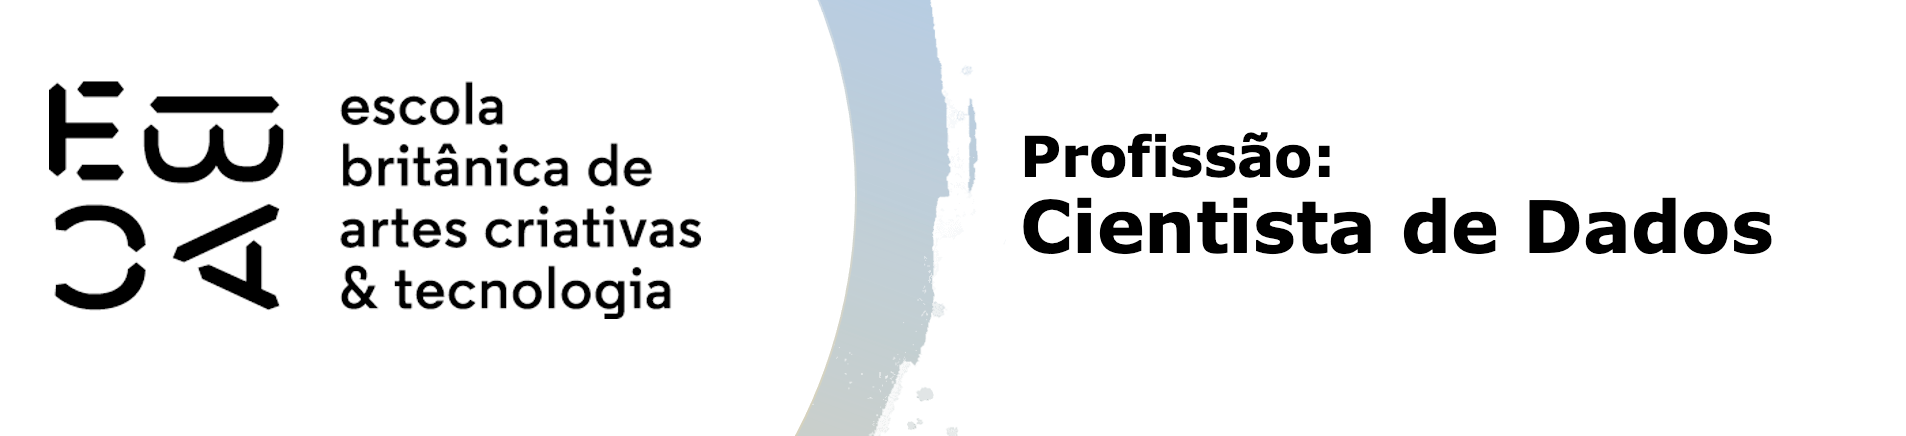

---

<!-- # **Profissão: Cientista de Dados** -->
### **Módulo 37** | Regressão Logistica II | Exercício II

**Aluno:** [Marcio da Silva](https://www.linkedin.com/in/marcio-d-silva/)<br>
**Data:** 05 de novembro de 2024.


---


# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [41]:
# Bibliotecas padrão
import warnings

# Bibliotecas para manipulação de dados
import pandas as pd
import numpy as np

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Bibliotecas para análise estatística
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp, t
import scipy.stats as stats

# Bibliotecas de métricas de machine learning
from sklearn import metrics

# Ignorar avisos (com cuidado)
warnings.filterwarnings('ignore')


In [2]:
# Leitura do arquivo Feather
df = pd.read_feather('credit_scoring.ftr')

# Exibindo as primeiras linhas do DataFrame
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
# Exibe informações gerais sobre o DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [4]:
# Verificando o tipo da coluna data_ref e convertendo para datetime se necessário
df['data_ref'] = pd.to_datetime(df['data_ref'], errors='coerce')

# Exibindo os valores mínimo e máximo de data_ref
print("Data de referência mínima:", df['data_ref'].min())
print("Data de referência máxima:", df['data_ref'].max())

Data de referência mínima: 2015-01-01 00:00:00
Data de referência máxima: 2016-03-01 00:00:00


In [5]:
# Definindo 'data_ref' como índice
df.set_index('data_ref', inplace=True)

# Criando subconjuntos de treino e teste com base nas datas
df_train = df['2015-01-01':'2015-12-01']
df_test = df['2016-01-01':]

# Resetando o índice para que 'data_ref' seja uma coluna novamente
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

# Extraindo o mês de 'data_ref' para o conjunto de treino
df_train['mes'] = df_train['data_ref'].dt.month

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

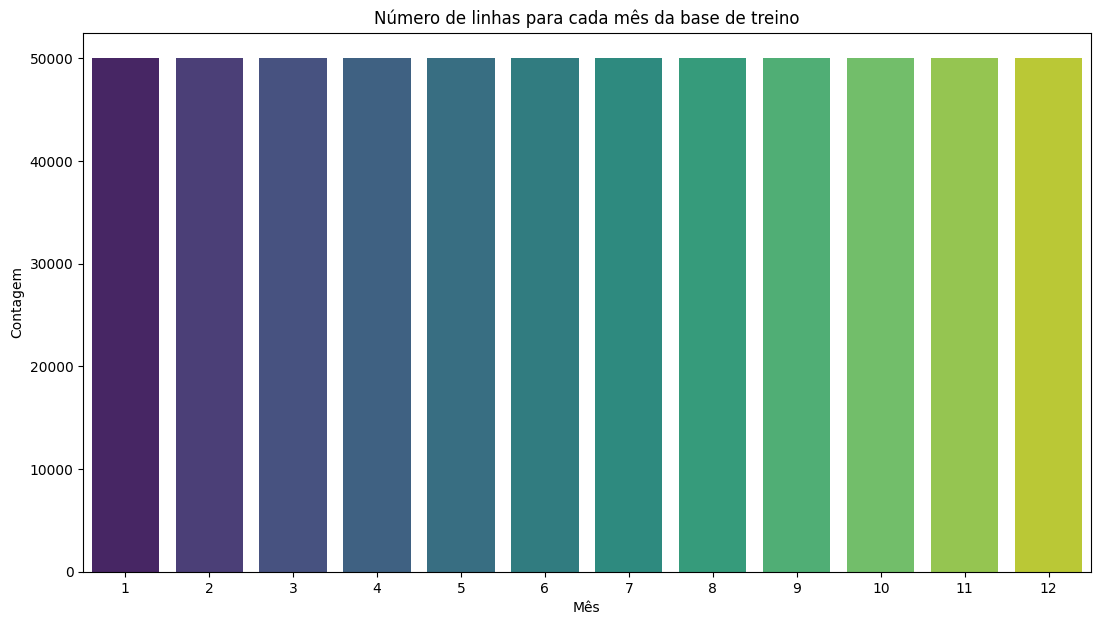

In [6]:
# Criando o gráfico de contagem
plt.figure(figsize=(13, 7))
sns.countplot(data=df_train, x='mes', palette='viridis')

# Título e rótulos
plt.title('Número de linhas para cada mês da base de treino')
plt.xlabel('Mês')
plt.ylabel('Contagem')

# Exibindo o gráfico
plt.show()

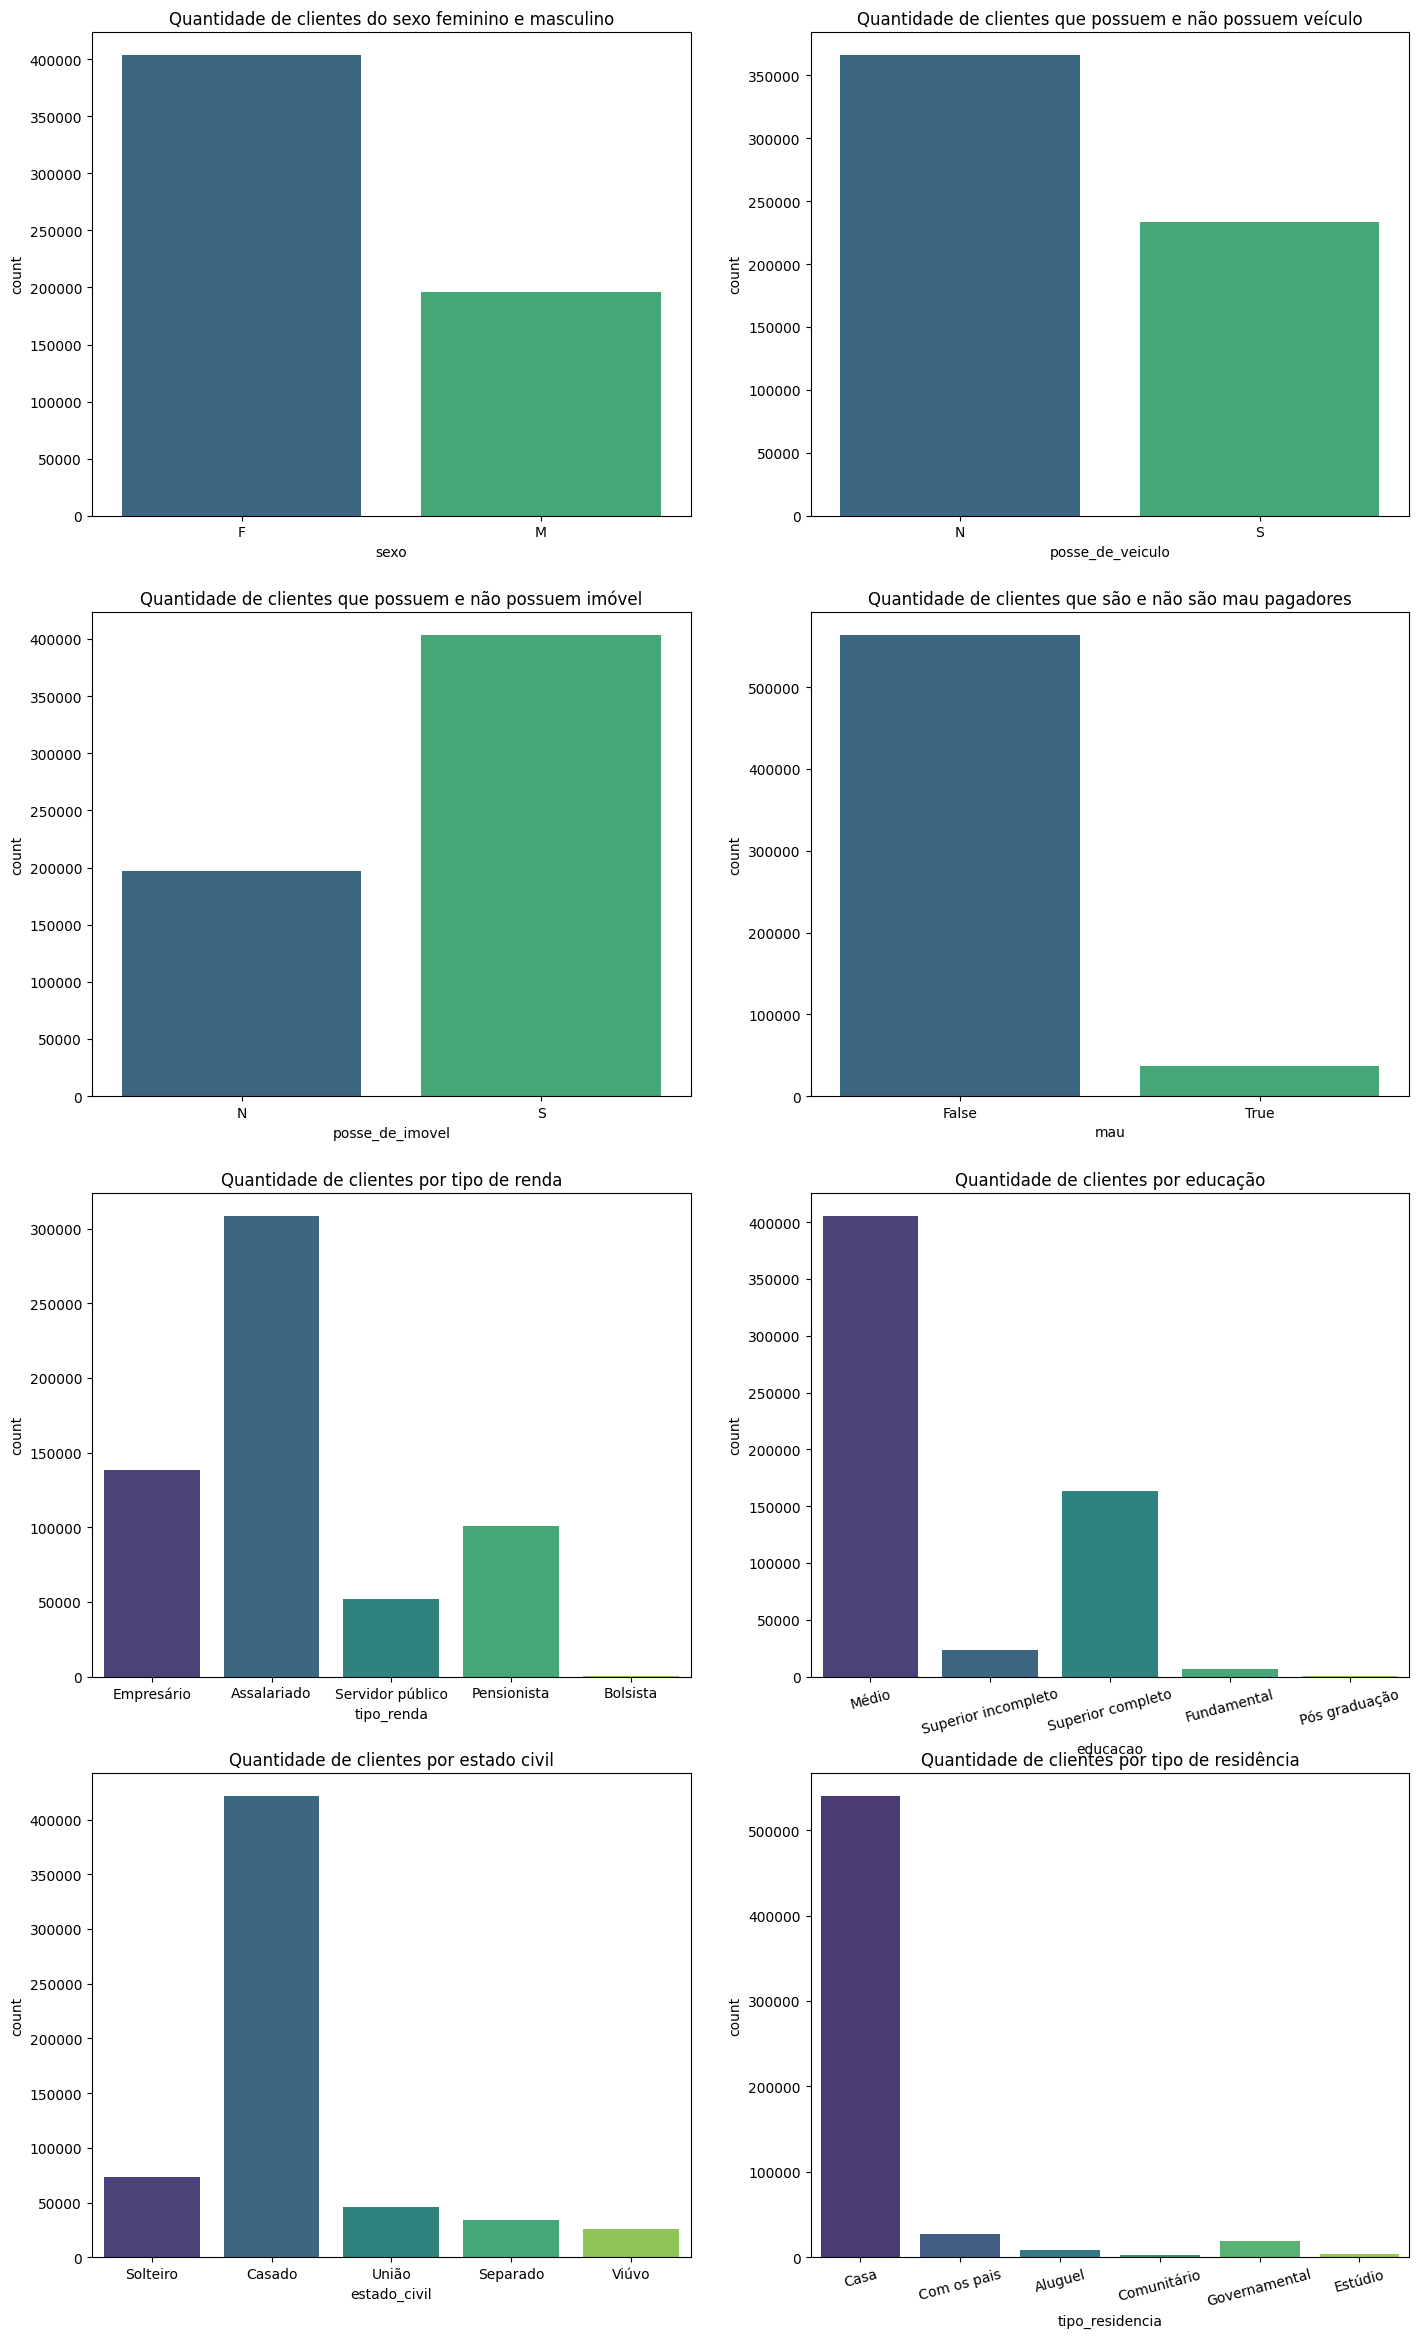

In [7]:
# Lista das variáveis para simplificação
columns = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'mau', 
           'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
titles = ['Quantidade de clientes do sexo feminino e masculino', 
          'Quantidade de clientes que possuem e não possuem veículo', 
          'Quantidade de clientes que possuem e não possuem imóvel', 
          'Quantidade de clientes que são e não são mau pagadores',
          'Quantidade de clientes por tipo de renda', 
          'Quantidade de clientes por educação', 
          'Quantidade de clientes por estado civil',
          'Quantidade de clientes por tipo de residência']

# Criando a figura com 4 linhas e 2 colunas
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(17, 28.9))

# Iterando sobre as colunas e títulos para gerar os gráficos
for i, (col, title) in enumerate(zip(columns, titles)):
    row, col_idx = divmod(i, 2)  # Calculando a linha e coluna para o grid
    sns.countplot(data=df_train, x=col, palette='viridis', ax=ax[row, col_idx])
    ax[row, col_idx].set_title(title)
    
    # Aplicando rotação de 15 graus para rótulos do eixo X, caso necessário
    if col in ['educacao', 'tipo_residencia']:
        for tick in ax[row, col_idx].get_xticklabels():
            tick.set_rotation(15)

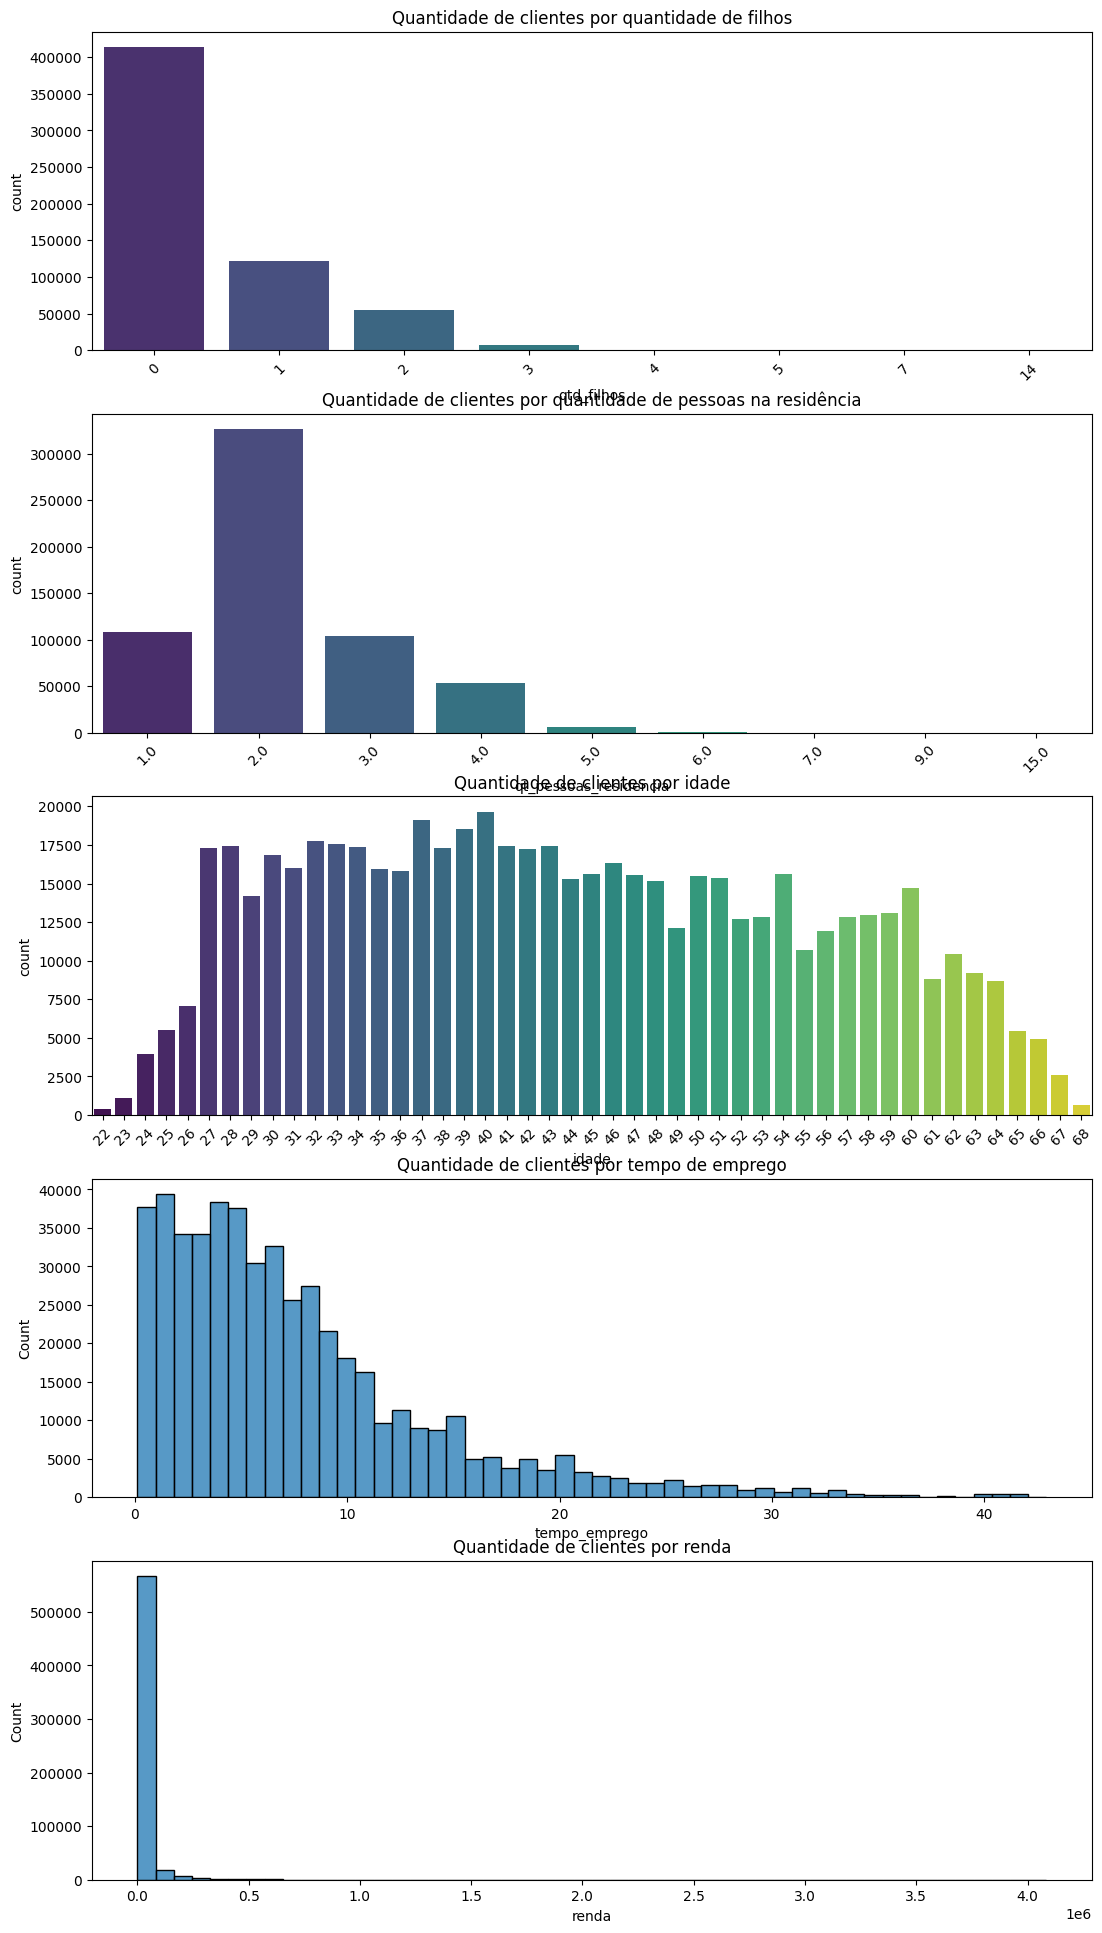

In [8]:
# Definindo as colunas e títulos
columns = ['qtd_filhos', 'qt_pessoas_residencia', 'idade', 'tempo_emprego', 'renda']
titles = ['Quantidade de clientes por quantidade de filhos', 
          'Quantidade de clientes por quantidade de pessoas na residência', 
          'Quantidade de clientes por idade', 
          'Quantidade de clientes por tempo de emprego', 
          'Quantidade de clientes por renda']

# Criando a figura com 5 linhas e 1 coluna
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12.9, 24))

# Iterando sobre as colunas e títulos para gerar os gráficos
for i, (col, title) in enumerate(zip(columns, titles)):
    if col in ['qtd_filhos', 'qt_pessoas_residencia', 'idade']:  # Countplot para colunas categóricas
        sns.countplot(data=df_train, x=col, palette='viridis', ax=ax[i])
    else:  # Histplot para colunas numéricas (tempo_emprego, renda)
        sns.histplot(data=df_train, x=col, palette='dark', bins=50, ax=ax[i])
    
    ax[i].set_title(title)
    
    # Aplicando rotação nos rótulos do eixo x, se necessário (para colunas com mais categorias)
    if col in ['qtd_filhos', 'qt_pessoas_residencia', 'idade']:
        for tick in ax[i].get_xticklabels():
            tick.set_rotation(45)


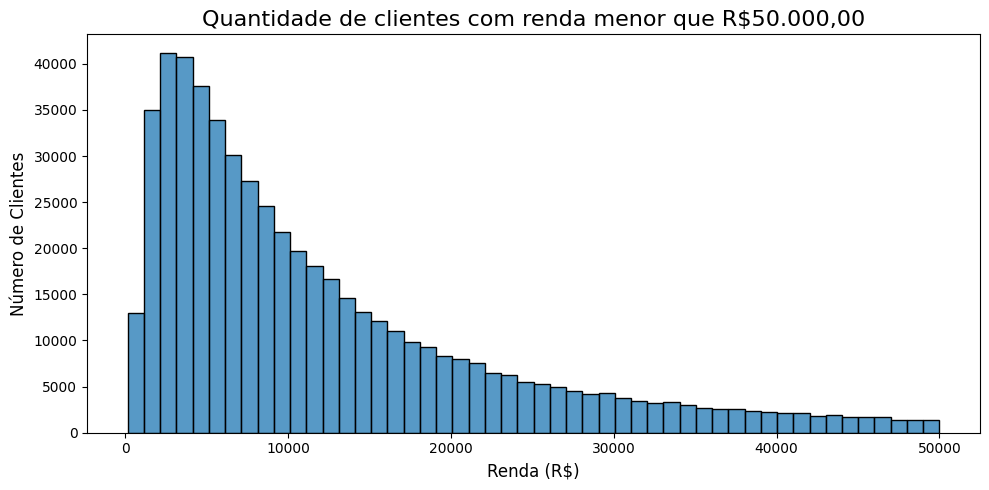

In [9]:
# Criando o gráfico
fig, ax = plt.subplots(figsize=(10, 5))

# Filtrando e gerando o histograma
sns.histplot(data=df_train[df_train.renda < 50000], x='renda', palette='dark', bins=50, ax=ax)

# Definindo título e rótulos
ax.set_title('Quantidade de clientes com renda menor que R$50.000,00', fontsize=16)
ax.set_xlabel('Renda (R$)', fontsize=12)
ax.set_ylabel('Número de Clientes', fontsize=12)

# Ajustando o layout
plt.tight_layout()

# Exibindo o gráfico
plt.show()

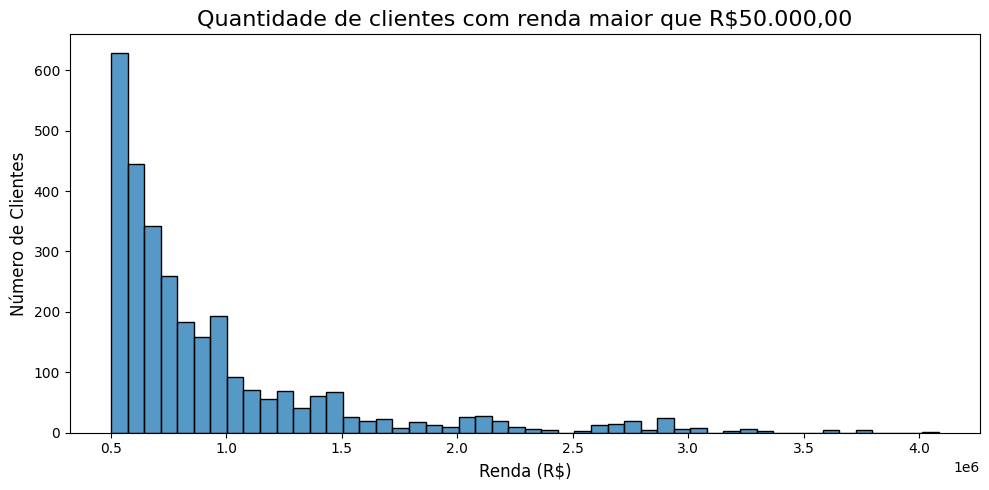

In [10]:
# Criando o gráfico
fig, ax = plt.subplots(figsize=(10, 5))

# Filtrando e gerando o histograma para rendas maiores que R$500.000,00
sns.histplot(data=df_train[df_train.renda > 500000], x='renda', palette='dark', bins=50, ax=ax)

# Definindo título e rótulos
ax.set_title('Quantidade de clientes com renda maior que R$50.000,00', fontsize=16)
ax.set_xlabel('Renda (R$)', fontsize=12)
ax.set_ylabel('Número de Clientes', fontsize=12)

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

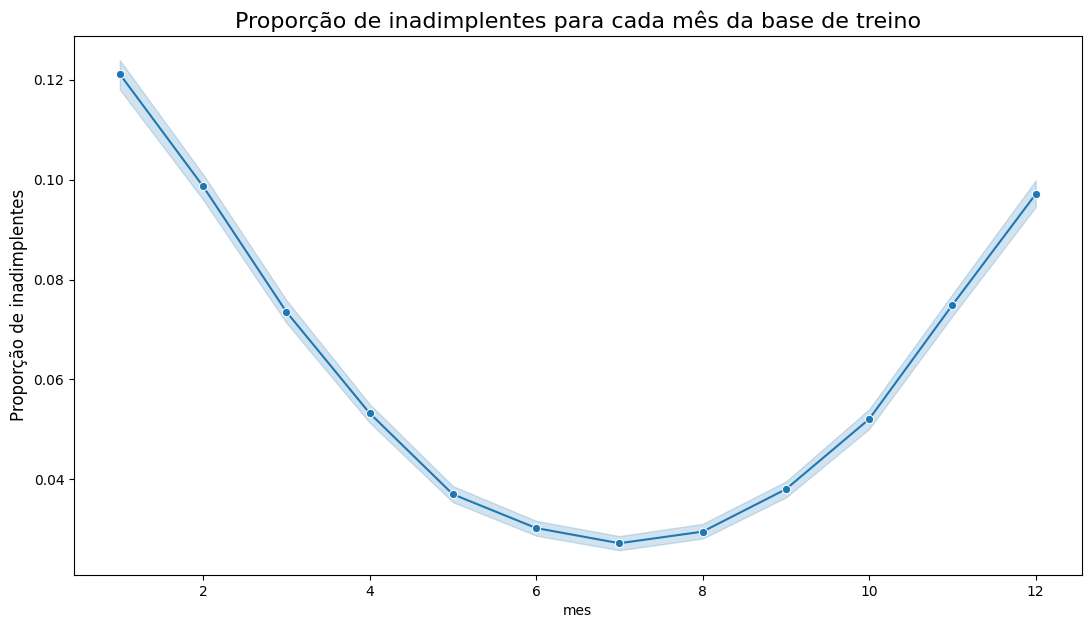

In [11]:
# Criando o gráfico de linha
fig, ax = plt.subplots(figsize=(13, 7))
sns.lineplot(data=df_train, x='mes', y='mau', marker='o')

# Definindo o título e rótulos
ax.set_title('Proporção de inadimplentes para cada mês da base de treino', fontsize=16)
ax.set_ylabel("Proporção de inadimplentes", fontsize=12)

# Exibindo o gráfico
plt.show()


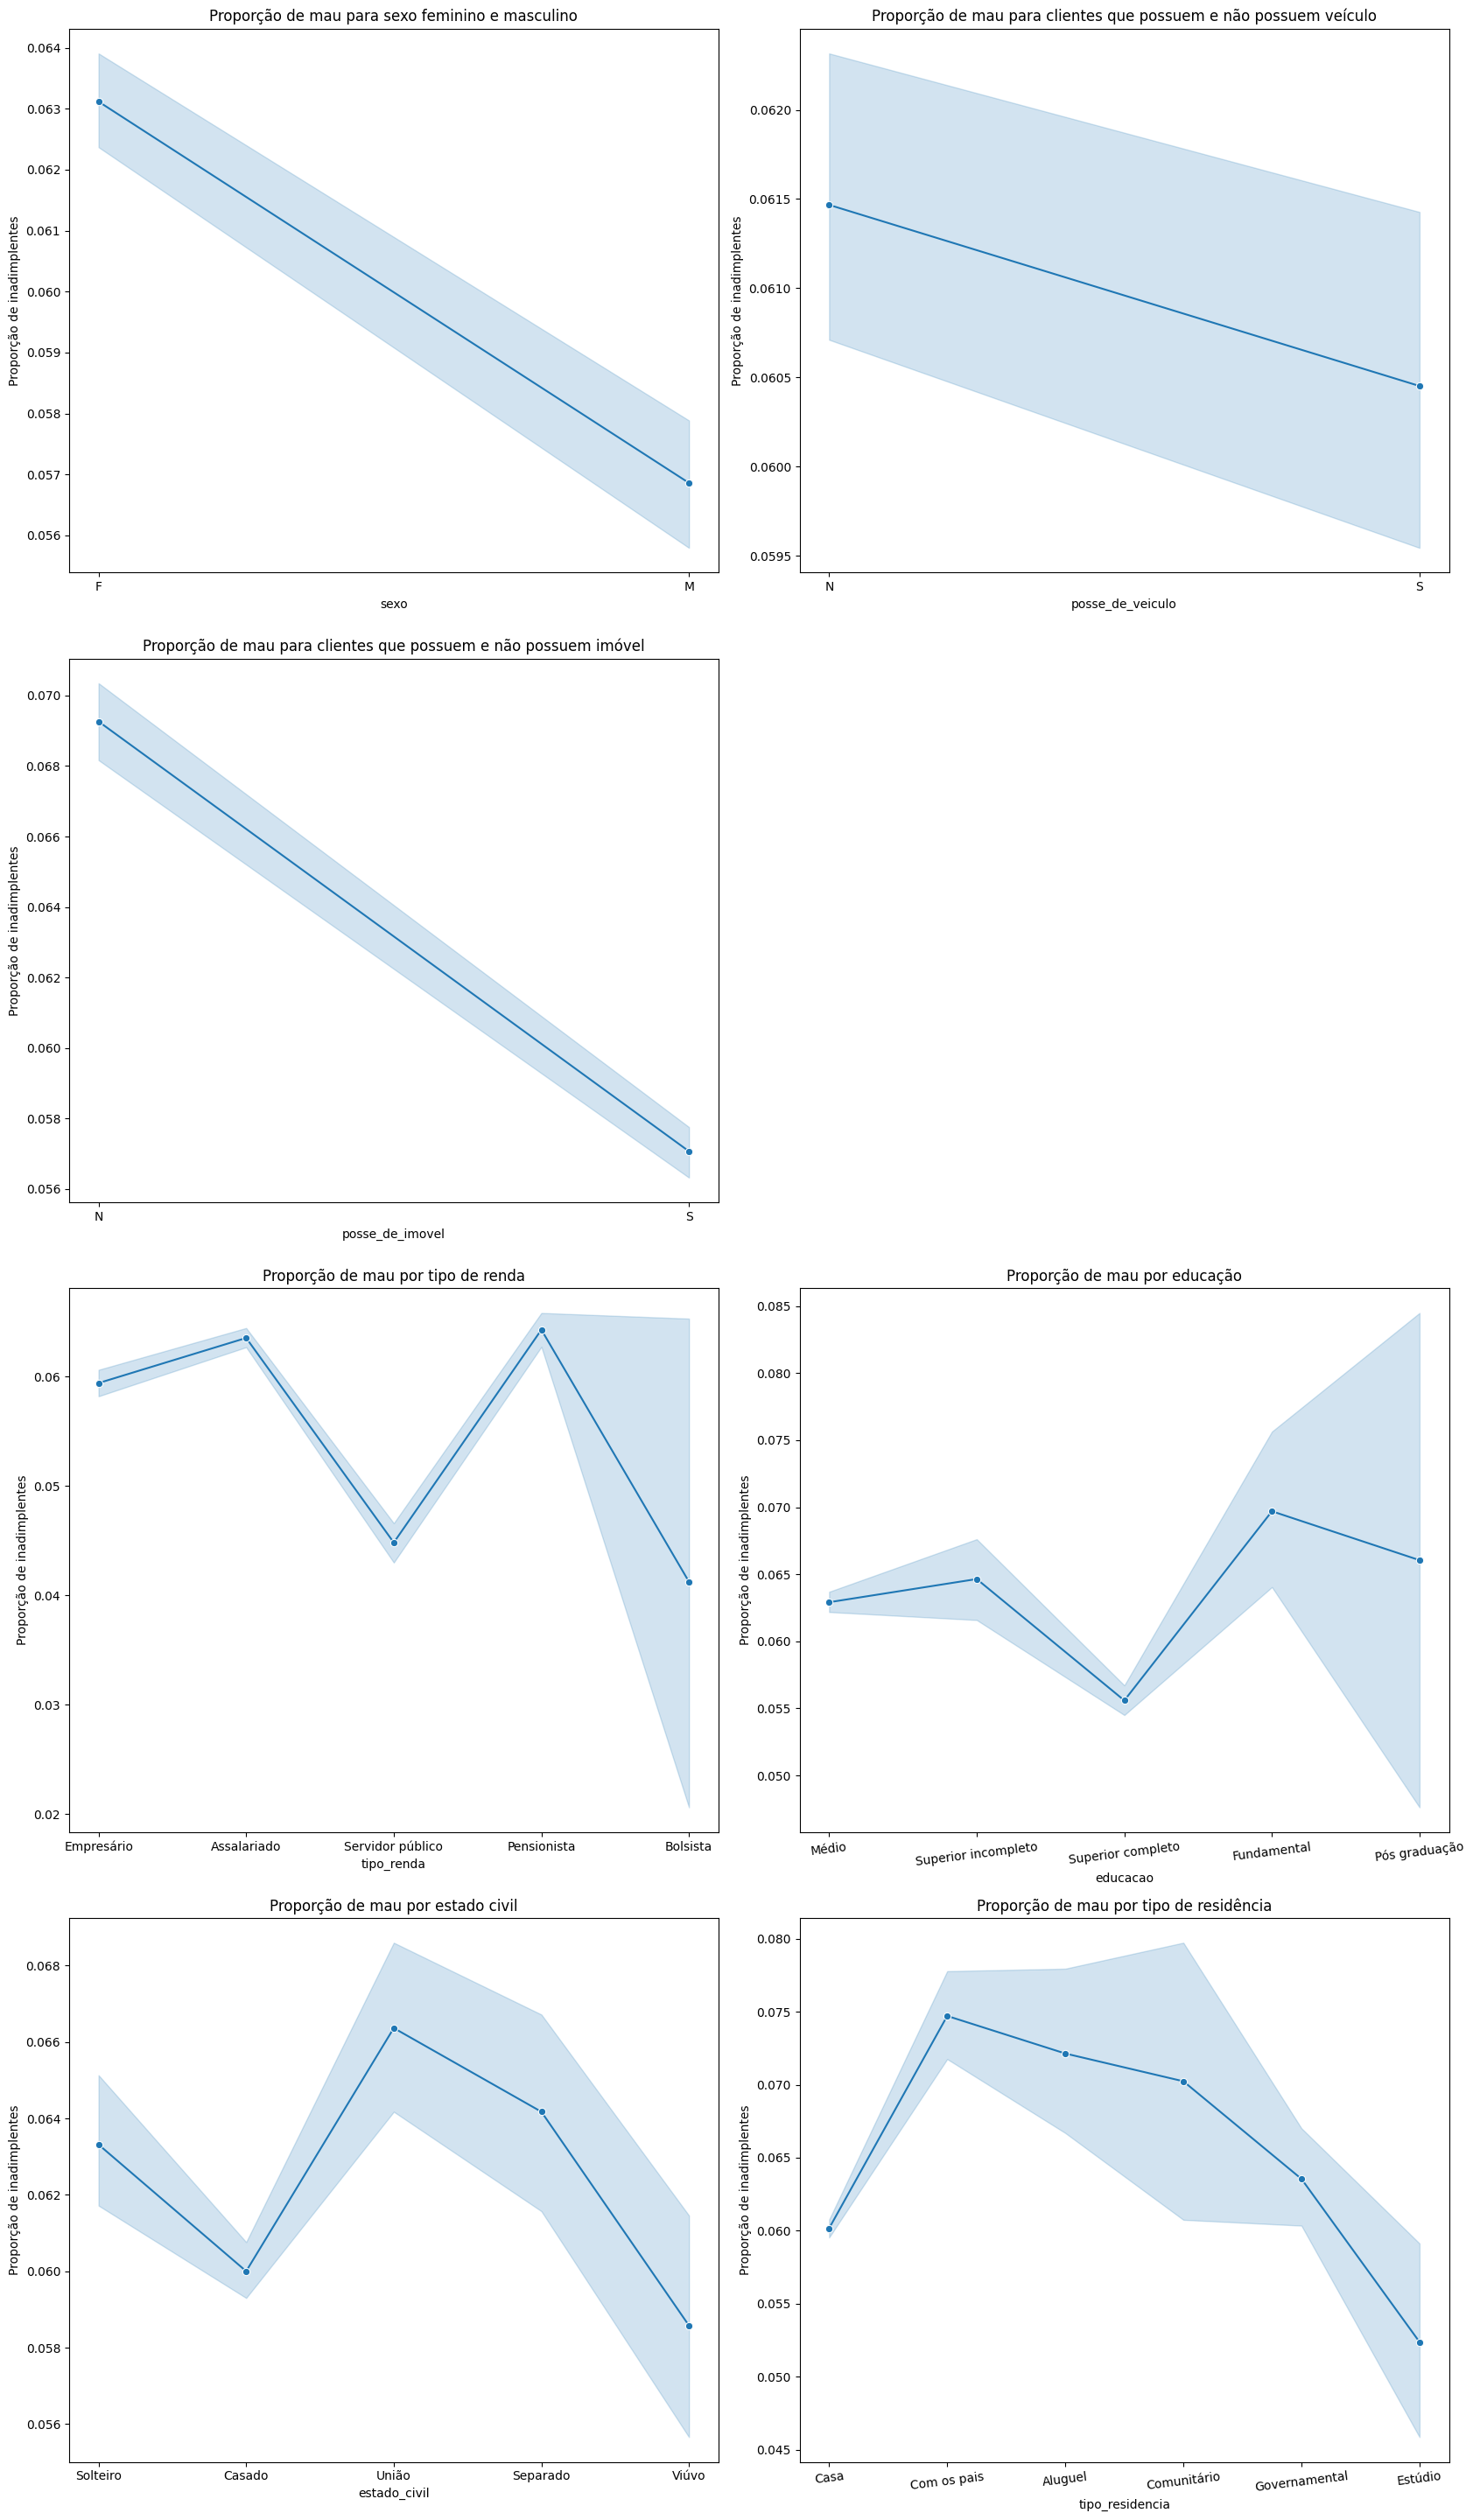

CPU times: user 43.2 s, sys: 2.73 s, total: 45.9 s
Wall time: 46.2 s


In [12]:
%%time
# Criando o grid de subgráficos
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(17, 28.9))

# Lista de configurações para os gráficos
grafico_config = [
    ('sexo', 'Proporção de mau para sexo feminino e masculino', ax[0, 0]),
    ('posse_de_veiculo', 'Proporção de mau para clientes que possuem e não possuem veículo', ax[0, 1]),
    ('posse_de_imovel', 'Proporção de mau para clientes que possuem e não possuem imóvel', ax[1, 0]),
    ('tipo_renda', 'Proporção de mau por tipo de renda', ax[2, 0]),
    ('educacao', 'Proporção de mau por educação', ax[2, 1]),
    ('estado_civil', 'Proporção de mau por estado civil', ax[3, 0]),
    ('tipo_residencia', 'Proporção de mau por tipo de residência', ax[3, 1]),
]

# Plotando os gráficos
for coluna, titulo, eixo in grafico_config:
    sns.lineplot(data=df_train, x=coluna, y='mau', palette='viridis', ax=eixo, marker='o')
    eixo.set_title(titulo)
    eixo.set_ylabel("Proporção de inadimplentes")
    if coluna in ['educacao', 'tipo_residencia']:
        for tick in eixo.get_xticklabels():
            tick.set_rotation(7)  # Rotacionando os rótulos para maior legibilidade

# Espaço vazio no gráfico
ax[1, 1].axis('off')

# Ajustando o layout para evitar sobreposição de títulos e labels
plt.tight_layout()

# Exibindo os gráficos
plt.show()


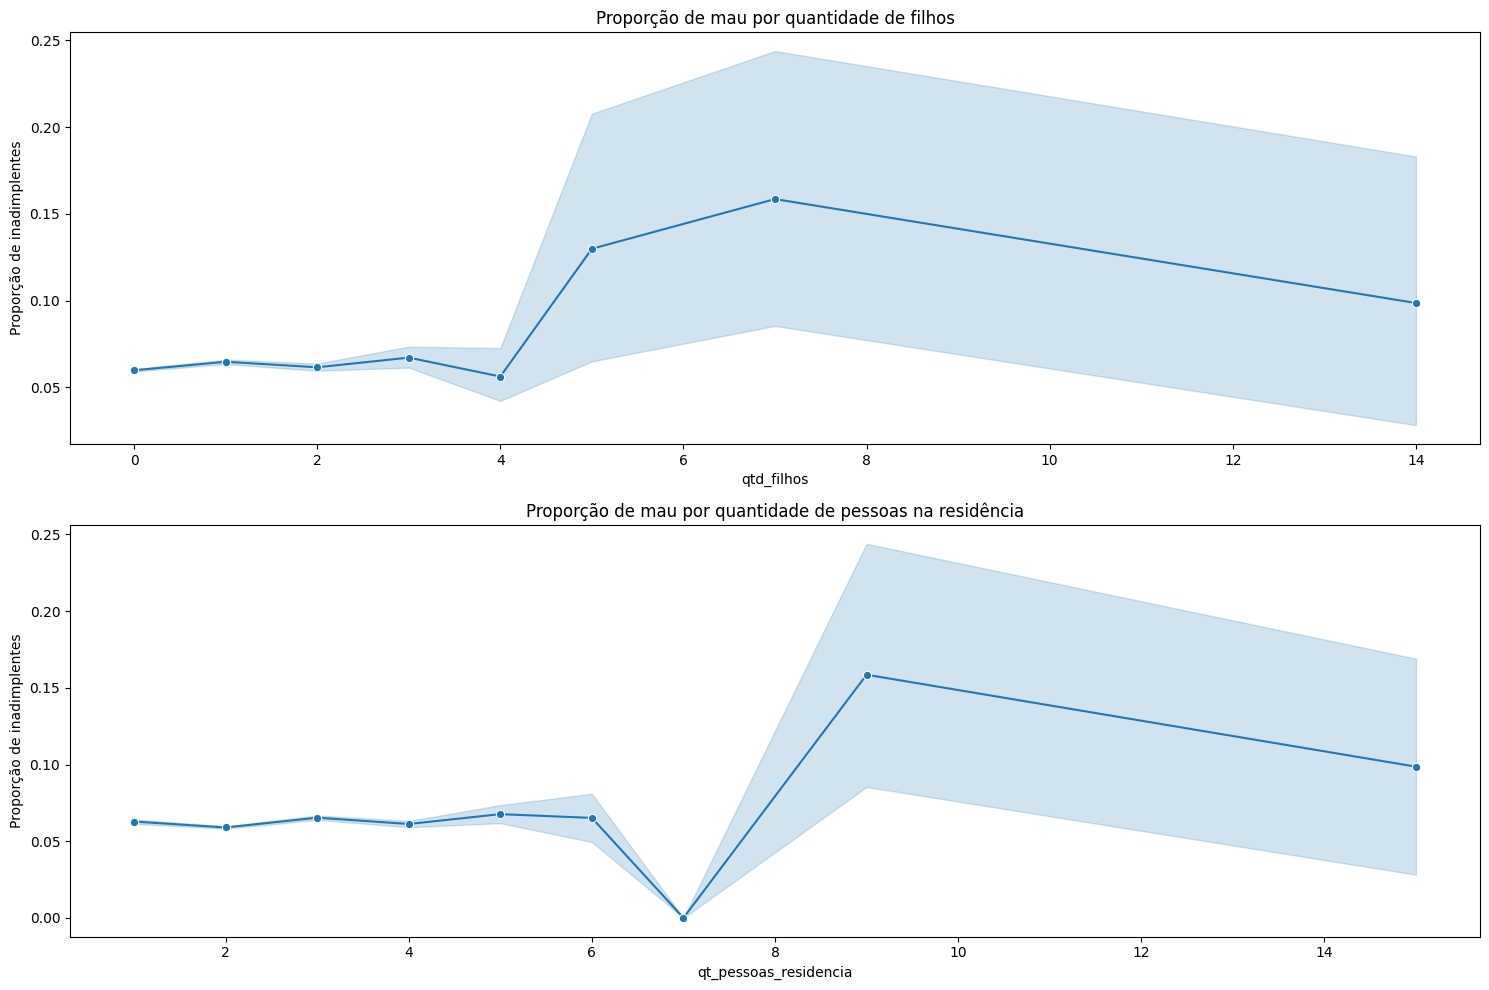

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Lista com as variáveis e títulos para os gráficos
config = [
    ('qtd_filhos', 'Proporção de mau por quantidade de filhos'),
    ('qt_pessoas_residencia', 'Proporção de mau por quantidade de pessoas na residência')
]

# Loop para criar os gráficos
for i, (coluna, titulo) in enumerate(config):
    sns.lineplot(data=df_train, x=coluna, y='mau', palette='viridis', ax=ax[i], marker='o')
    ax[i].set_title(titulo)
    ax[i].set_ylabel("Proporção de inadimplentes")

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()


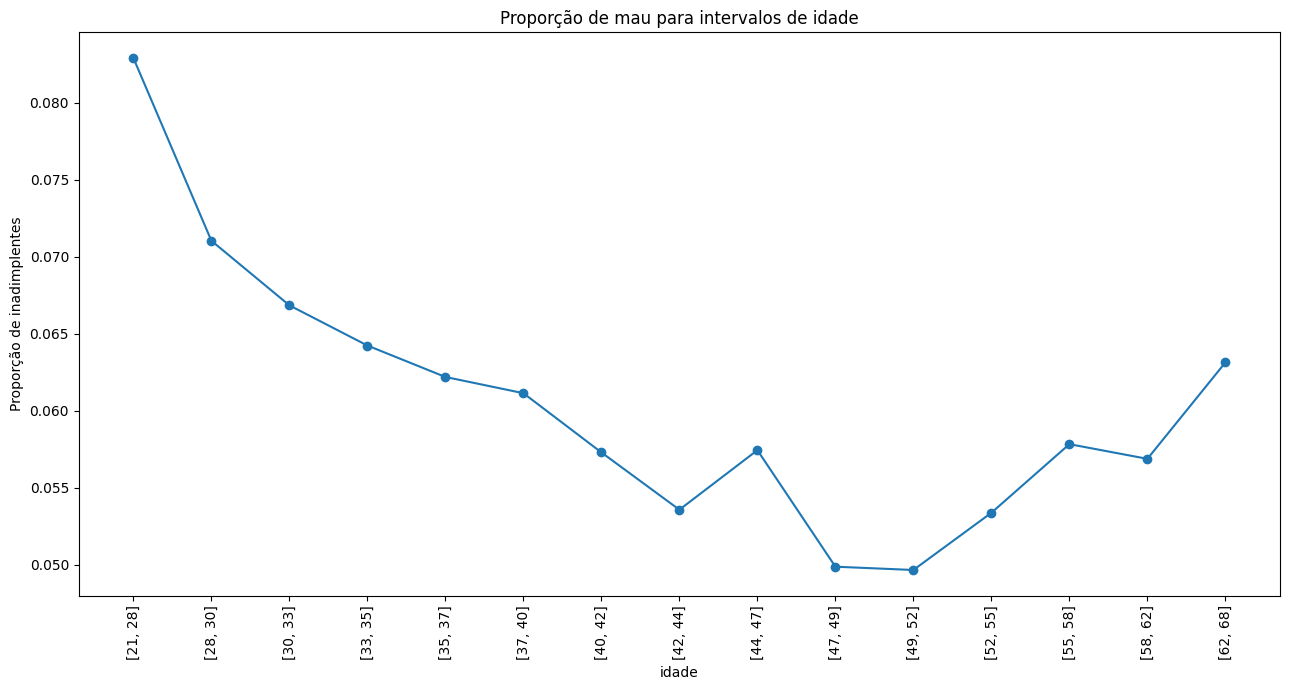

In [14]:
fig, ax = plt.subplots(figsize=(13, 7))

# Dividindo a variável 'idade' em 15 quantis e calculando a proporção de inadimplentes
biv = df_train.groupby(pd.qcut(df_train['idade'], 15))['mau'].mean()

# Plotando a linha
biv.plot.line(marker='o', ax=ax)
ax.set_ylabel("Proporção de inadimplentes")
ax.set_title('Proporção de mau para intervalos de idade')

# Ajustando os rótulos no eixo x (garantindo que o número de ticks seja adequado)
ax.set_xticks(range(len(biv)))  # Definindo os ticks com base no número de intervalos
ax.set_xticklabels([f'[{int(interval.left)}, {int(interval.right)}]' for interval in biv.index], rotation=90)

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()


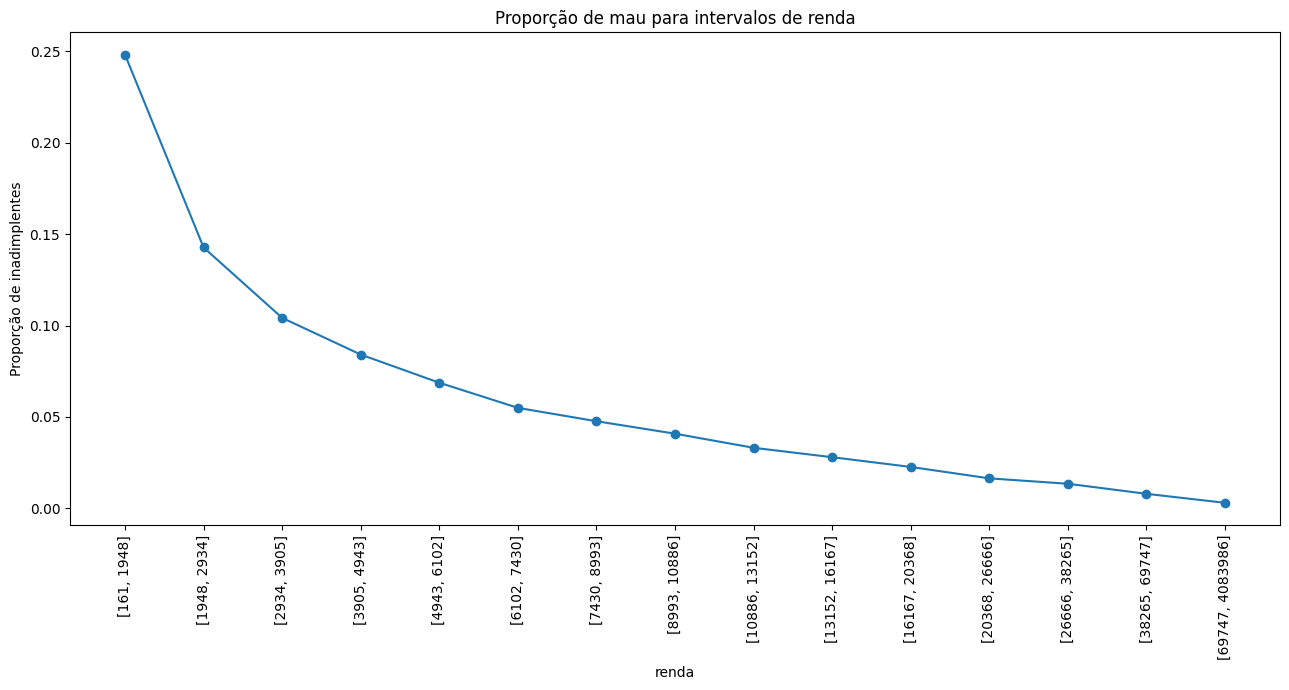

In [15]:
fig, ax = plt.subplots(figsize=(13, 7))

# Calculando a média de inadimplentes por intervalo de renda e plotando
biv = df_train.groupby(pd.qcut(df_train['renda'], 15))['mau'].mean()

# Plotando a linha com marcador
biv.plot.line(marker='o', ax=ax)
ax.set_ylabel("Proporção de inadimplentes")
ax.set_title('Proporção de mau para intervalos de renda')

# Ajustando os rótulos do eixo x para exibir os intervalos de renda
ax.set_xticks(range(len(biv)))
ax.set_xticklabels([f'[{int(interval.left)}, {int(interval.right)}]' for interval in biv.index], rotation=90)

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [16]:
def IV(variavel, resposta):
    # Tabela de contingência com totais
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    # Identificação das colunas de evento e não evento
    tilo_evento, tilo_nao_evento = tab.columns[:2]

    # Cálculo das porcentagens e WOEs
    pct_evento = tab[tilo_evento] / tab.loc['total', tilo_evento]
    pct_nao_evento = tab[tilo_nao_evento] / tab.loc['total', tilo_nao_evento]
    woe = np.log(pct_evento / pct_nao_evento)

    # Cálculo do IV Parcial
    iv_parcial = (pct_evento - pct_nao_evento) * woe

    # Retorna o IV total
    return iv_parcial.sum()


In [17]:
def biv_discreta(var, df):
    # Calculando as variáveis necessárias
    df['bom'] = 1 - df.mau
    g = df.groupby(var)

    # Construindo o DataFrame de estatísticas
    biv = g[var].agg(
        qt_bom=('bom', 'sum'),
        qt_mau=('mau', 'sum'),
        mau=('mau', 'mean'),
        cont=('mau', 'count')
    )

    # Cálculos dos intervalos de confiança e logit
    biv['ep'] = np.sqrt((biv.mau * (1 - biv.mau)) / biv.cont)
    biv['mau_sup'] = biv.mau + t.ppf(0.975, biv.cont - 1) * biv.ep
    biv['mau_inf'] = biv.mau + t.ppf(0.025, biv.cont - 1) * biv.ep

    biv['logit'] = np.log(biv.mau / (1 - biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup / (1 - biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf / (1 - biv.mau_inf))

    # Cálculo do WOE
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))
    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    # Plotando os gráficos
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))

    # Gráfico de WOE e seus limites
    ax[0].plot(biv.index, biv.woe, ':bo', label='woe')
    ax[0].plot(biv.index, biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv.index, biv.woe_inf, 'o:r', label='limite inferior')
    ax[0].set_xlim([-.3, len(biv) - .7])
    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    ax[0].set_xticks(range(len(biv)))
    ax[0].set_xticklabels(biv.index, rotation=8)

    # Gráfico de barras
    ax[1].bar(biv.index, biv.cont)
    ax[1].set_ylabel("Contagem")

    plt.tight_layout()
    plt.show()

    return biv


In [18]:
def biv_continua(var, ncat, df):
    # Calculando a variável 'bom' e as categorias
    df['bom'] = 1 - df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    
    # Agrupando e calculando as estatísticas
    biv = df.groupby(cat_srs).agg(
        qt_bom=('bom', 'sum'),
        qt_mau=('mau', 'sum'),
        mau=('mau', 'mean'),
        cont=(var, 'count')
    )
    
    # Calculando intervalos de confiança, logit e WOE
    biv['ep'] = np.sqrt((biv.mau * (1 - biv.mau)) / biv.cont)
    biv['mau_sup'] = biv.mau + t.ppf(0.975, biv.cont - 1) * biv.ep
    biv['mau_inf'] = biv.mau + t.ppf(0.025, biv.cont - 1) * biv.ep
    biv['logit'] = np.log(biv.mau / (1 - biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup / (1 - biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf / (1 - biv.mau_inf))

    # Cálculo de WOE
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))
    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    # Plotando os resultados
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))

    # Gráfico de WOE e seus limites
    ax[0].plot(biv.index, biv.woe, ':bo', label='woe')
    ax[0].plot(biv.index, biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv.index, biv.woe_inf, 'o:r', label='limite inferior')
    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    # Gráfico de contagem
    biv['cont'].plot.bar(ax=ax[1])

    plt.tight_layout()
    plt.show()

    return None


In [19]:
# Remover as colunas indesejadas e converter 'mau' para inteiro de uma só vez
df_train.drop(columns=['data_ref', 'index', 'mes'], inplace=True)
df_train['mau'] = df_train['mau'].astype(int)

# Exibir informações do DataFrame
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   600000 non-null  object 
 1   posse_de_veiculo       600000 non-null  object 
 2   posse_de_imovel        600000 non-null  object 
 3   qtd_filhos             600000 non-null  int64  
 4   tipo_renda             600000 non-null  object 
 5   educacao               600000 non-null  object 
 6   estado_civil           600000 non-null  object 
 7   tipo_residencia        600000 non-null  object 
 8   idade                  600000 non-null  int64  
 9   tempo_emprego          499125 non-null  float64
 10  qt_pessoas_residencia  600000 non-null  float64
 11  renda                  600000 non-null  float64
 12  mau                    600000 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 59.5+ MB


In [20]:
# Verificar se a coluna tem valores ausentes e preenchê-los com a média
df_train['tempo_emprego'].fillna(value=df_train['tempo_emprego'].mean(), inplace=True)


In [21]:
metadados = pd.DataFrame({
    'dtype': df_train.dtypes,
    'nmissing': df_train.isna().sum(),
    'valores_unicos': df_train.nunique()
}).assign(papel='covariavel')

# Atribuindo 'resposta' para a coluna 'papel' onde a linha é 'mau'
metadados.loc['mau', 'papel'] = 'resposta'

metadados


,dtype,nmissing,valores_unicos,papel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel
tempo_emprego,float64,0,3005,covariavel


In [22]:
def calcular_IV(var, df, n_bins=5):
    # Verifica a quantidade de valores únicos e aplica qcut se necessário
    if df[var].nunique() > 10:
        return IV(pd.qcut(df[var], n_bins, duplicates='drop'), df['mau'])
    else:
        return IV(df[var], df['mau'])

# Aplicando a função 'calcular_IV' apenas nas covariáveis
metadados['IV'] = metadados.apply(
    lambda row: calcular_IV(row.name, df_train) if row['papel'] == 'covariavel' else None, axis=1
)

metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0,2,covariavel,0.002665
posse_de_veiculo,object,0,2,covariavel,0.000075
posse_de_imovel,object,0,2,covariavel,0.009690
qtd_filhos,int64,0,8,covariavel,0.001689
tipo_renda,object,0,5,covariavel,0.009718
educacao,object,0,5,covariavel,0.003690
estado_civil,object,0,5,covariavel,0.001305
tipo_residencia,object,0,6,covariavel,0.003330
idade,int64,0,47,covariavel,0.018434
tempo_emprego,float64,0,3005,covariavel,0.283956


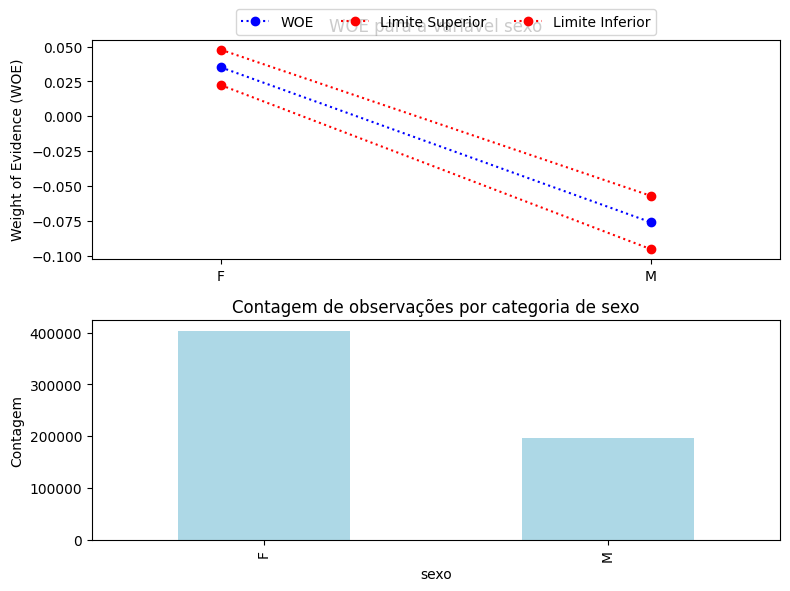

In [55]:
def biv_discreta(var, df):
    # Agrupar dados pela variável e calcular as métricas necessárias
    g = df.groupby(var)['mau'].agg(['sum', 'mean', 'count'])
    g['bom'] = g['count'] - g['sum']  # 'bom' é 1 - 'mau'
    
    # Erro padrão e intervalos de confiança
    g['ep'] = np.sqrt(g['mean'] * (1 - g['mean']) / g['count'])
    g['mau_sup'] = g['mean'] + t.ppf(0.975, g['count'] - 1) * g['ep']
    g['mau_inf'] = g['mean'] - t.ppf(0.975, g['count'] - 1) * g['ep']
    
    # WOE e seus limites
    woe_geral = np.log(df['mau'].mean() / (1 - df['mau'].mean()))
    g['woe'] = np.log(g['mean'] / (1 - g['mean'])) - woe_geral
    g['woe_sup'] = np.log(g['mau_sup'] / (1 - g['mau_sup'])) - woe_geral
    g['woe_inf'] = np.log(g['mau_inf'] / (1 - g['mau_inf'])) - woe_geral

    # Plotando os resultados
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    
    # Gráfico de WOE
    ax[0].plot(g.index, g['woe'], ':bo', label='WOE')
    ax[0].plot(g.index, g['woe_sup'], 'o:r', label='Limite Superior')
    ax[0].plot(g.index, g['woe_inf'], 'o:r', label='Limite Inferior')
    ax[0].set_xlim([-0.3, len(g) - 0.7])
    ax[0].set_ylabel("Weight of Evidence (WOE)")
    ax[0].set_title(f"WOE para a variável {var}")
    ax[0].legend(bbox_to_anchor=(0.83, 1.17), ncol=3)
    
    # Gráfico de contagem
    g['count'].plot.bar(ax=ax[1], color='lightblue')
    ax[1].set_ylabel("Contagem")
    ax[1].set_title(f"Contagem de observações por categoria de {var}")
    
    plt.tight_layout()

# Aplicando a função para a variável 'sexo' no df_train
biv_discreta('sexo', df_train)


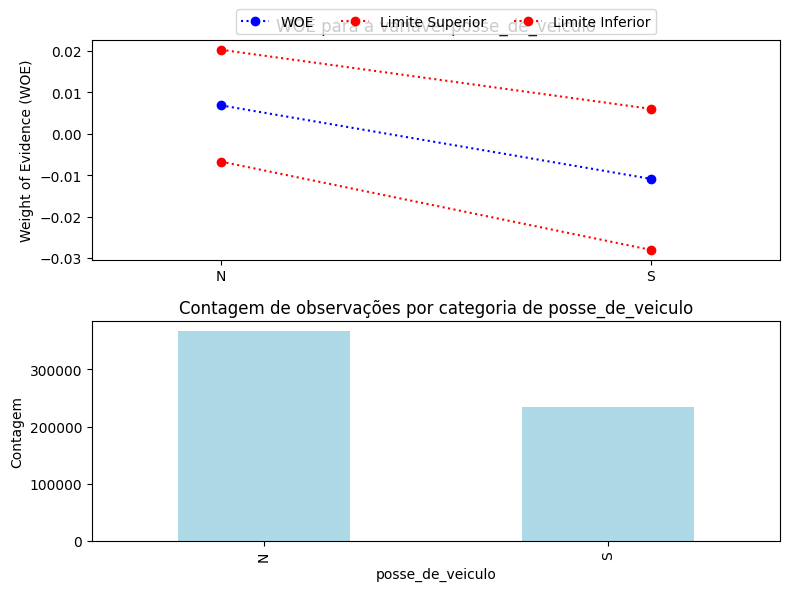

In [24]:
biv_discreta('posse_de_veiculo', df_train)

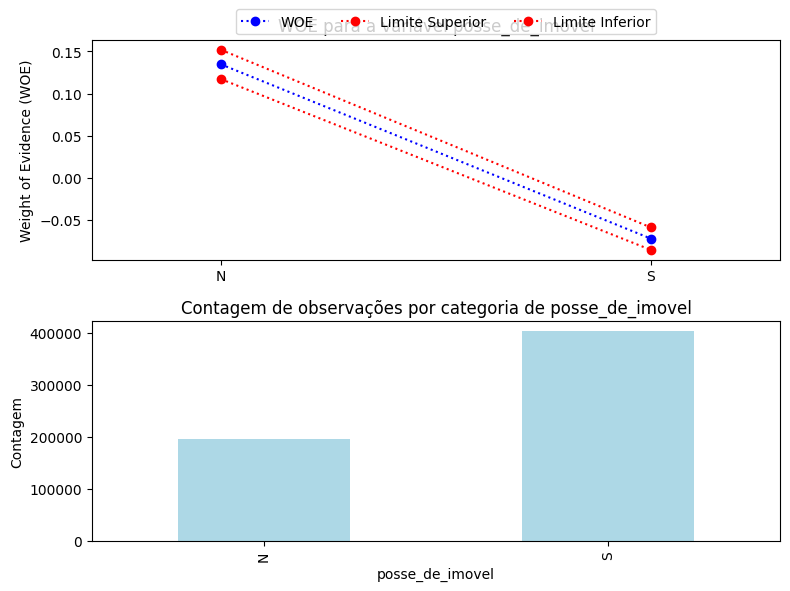

In [25]:
biv_discreta('posse_de_imovel', df_train)

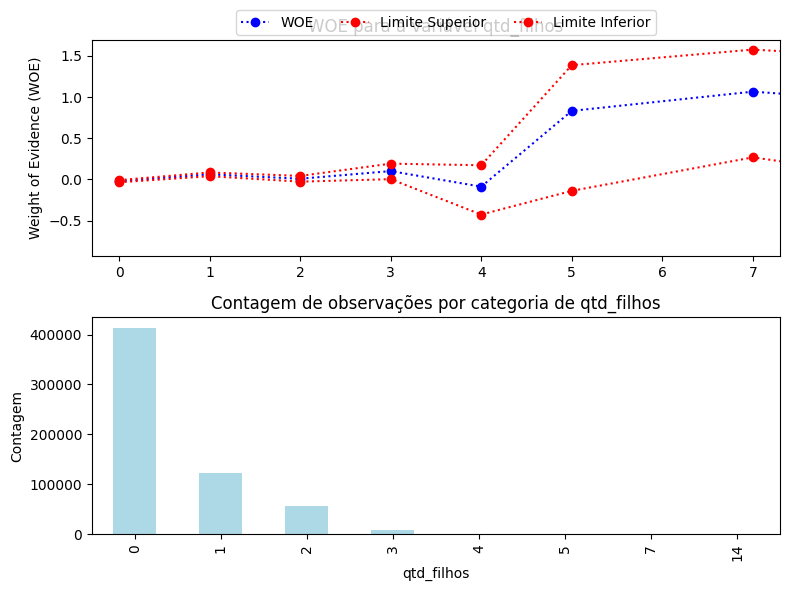

In [26]:
biv_discreta('qtd_filhos', df_train)

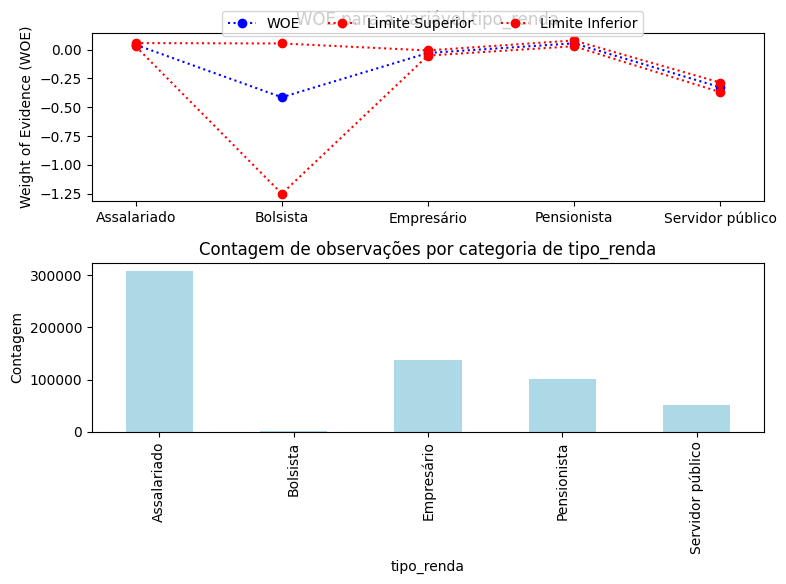

In [27]:
biv_discreta('tipo_renda', df_train)

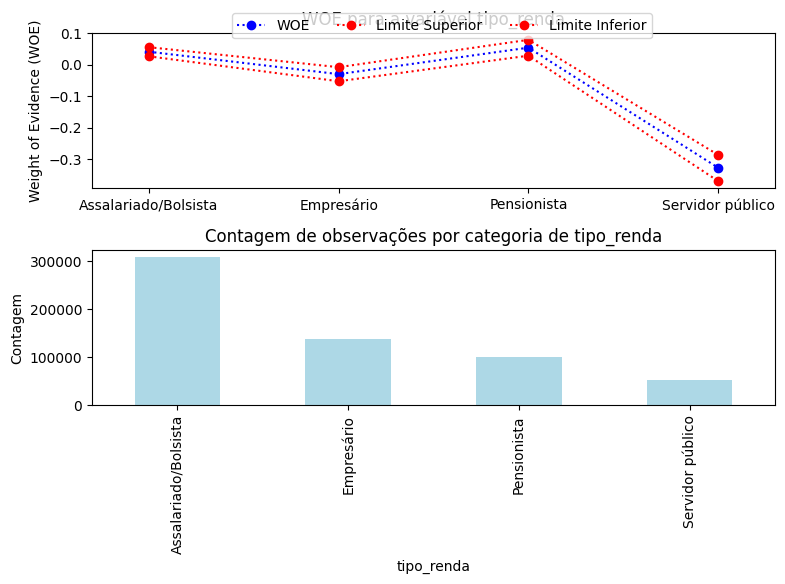

IV para a variável 'tipo_renda': 0.0096


In [44]:
# Substituindo as categorias de 'tipo_renda' de forma eficiente
tipo_renda_mapping = {
    'Assalariado': 'Assalariado/Bolsista',
    'Bolsista': 'Assalariado/Bolsista'
}

df_train['tipo_renda'].replace(tipo_renda_mapping, inplace=True)

# Análise Bivariada e Cálculo do IV de forma compacta
def analisar_agrupamento(var, df, resposta='mau', n_bins=5):
    """ Função para análise bivariada e cálculo do IV """
    # Função biv_discreta (mantenha sua implementação anterior ou a simplifique)
    biv_discreta(var, df)  # Chama a análise bivariada para o var
    
    # Cálculo do IV para a variável
    iv_value = IV(df[var], df[resposta])
    print(f"IV para a variável '{var}': {iv_value:.4f}")
    return iv_value

# Analisando 'tipo_renda'
iv_tipo_renda = analisar_agrupamento('tipo_renda', df_train)

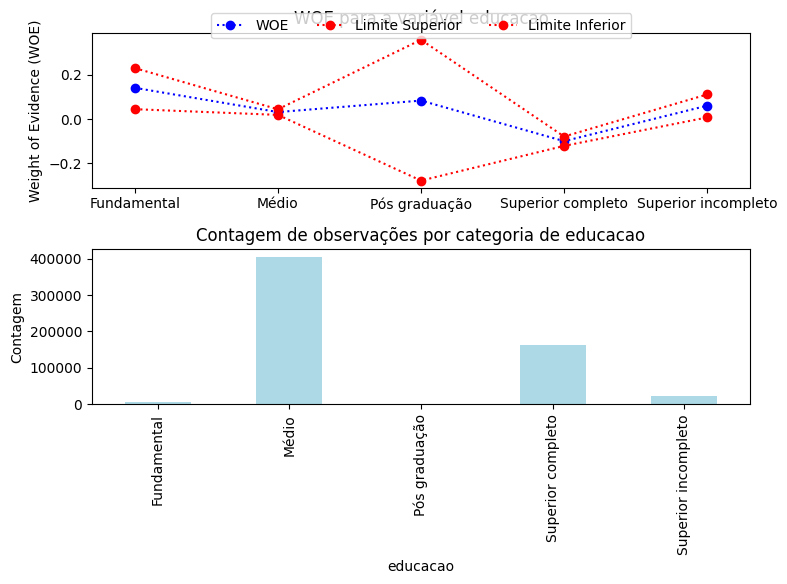

In [29]:
biv_discreta('educacao', df_train)

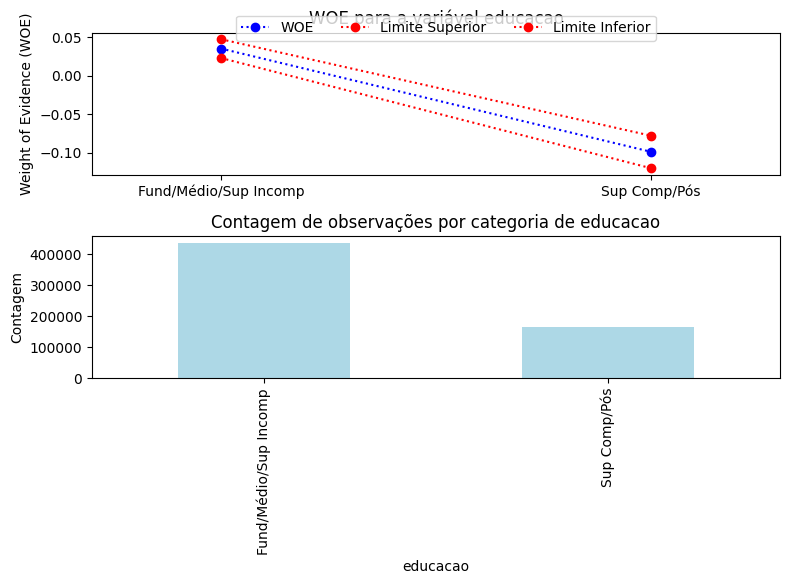

IV para a variável 'educacao': 0.0035


In [30]:
# Agrupando as classes da variável 'educacao' diretamente
df_train['educacao'].replace(
    {'Fundamental': 'Fund/Médio/Sup Incomp',
     'Médio': 'Fund/Médio/Sup Incomp',
     'Superior incompleto': 'Fund/Médio/Sup Incomp',
     'Superior completo': 'Sup Comp/Pós',
     'Pós graduação': 'Sup Comp/Pós'}, inplace=True)

# Realiza a análise bivariada e calcula o IV em uma única linha
biv_discreta('educacao', df_train)
iv_educacao = IV(df_train['educacao'], df_train['mau'])

print(f"IV para a variável 'educacao': {iv_educacao:.4f}")


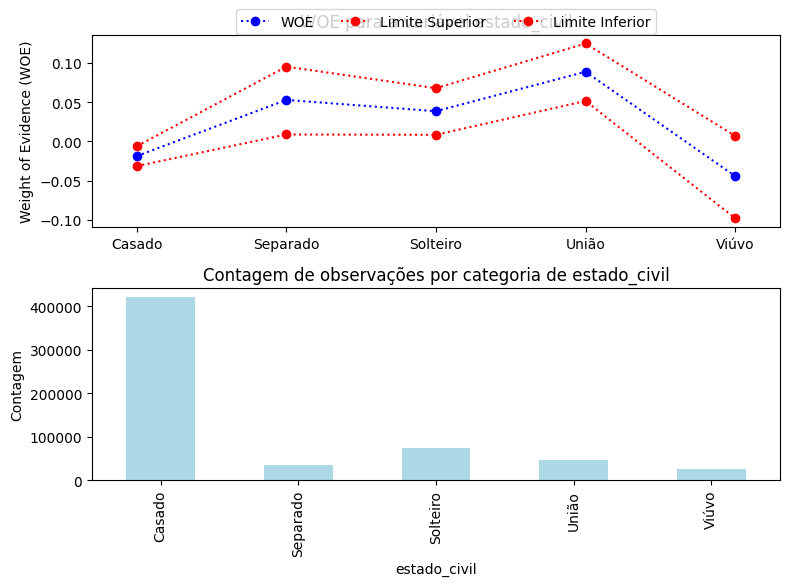

In [31]:
biv_discreta('estado_civil', df_train)

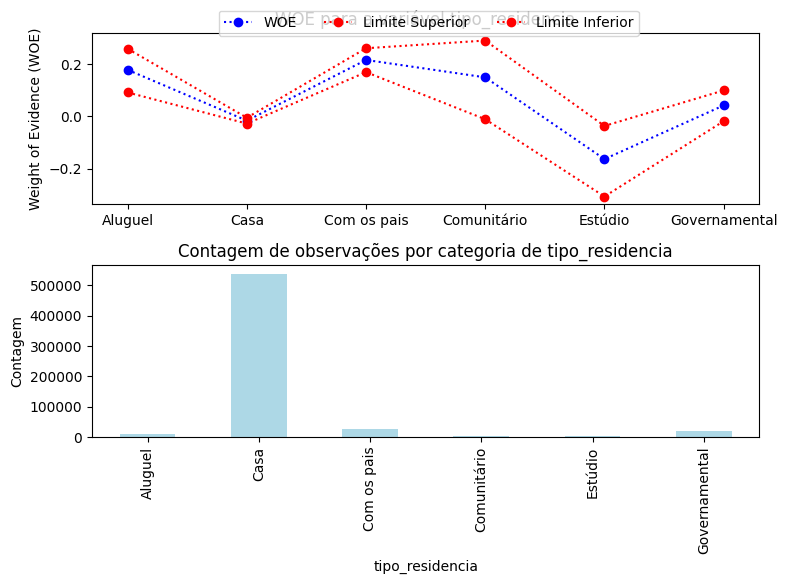

In [32]:
biv_discreta('tipo_residencia', df_train)


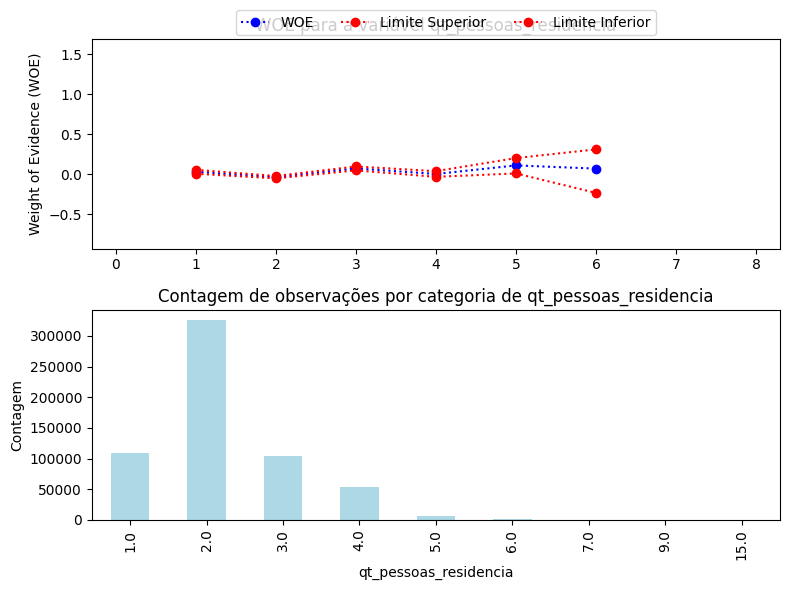

In [33]:
biv_discreta('qt_pessoas_residencia', df_train)


,categoria,qt_bom,qt_mau,mau,cont,ep,mau_sup,mau_inf,woe
0,0,125124,10011,0.074081,135135,0.000712,0.075478,0.072685,0.207070
1,1,115999,7703,0.062271,123702,0.000687,0.063617,0.060924,0.020719
2,2,108456,6470,0.056297,114926,0.000680,0.057630,0.054964,-0.086477
3,3,104348,5612,0.051037,109960,0.000664,0.052338,0.049736,-0.190133
4,4,109430,6847,0.058885,116277,0.000690,0.060238,0.057532,-0.038783


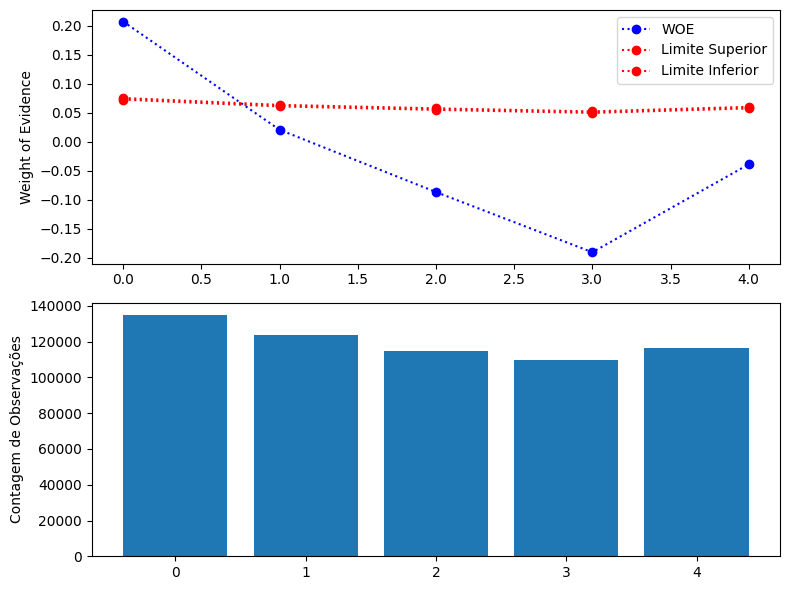

In [47]:
def biv_continua(var, ncat, df):
    # Agrupar em n categorias
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, labels=False, duplicates='drop')
    
    # Calcular as métricas de mau
    biv = df.groupby(cat_srs)['mau'].agg([lambda x: (1 - x).sum(), 'sum', 'mean', 'count']).reset_index()
    biv.columns = ['categoria', 'qt_bom', 'qt_mau', 'mau', 'cont']
    
    # Erro padrão e limites
    biv['ep'] = np.sqrt(biv.mau * (1 - biv.mau) / biv.cont)
    biv['mau_sup'] = biv.mau + stats.t.ppf(0.975, biv.cont - 1) * biv.ep
    biv['mau_inf'] = biv.mau - stats.t.ppf(0.975, biv.cont - 1) * biv.ep
    
    # Cálculos de WOE
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))
    biv['woe'] = np.log(biv.mau / (1 - biv.mau)) - woe_geral

    # Gráfico
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    ax[0].plot(biv['categoria'], biv['woe'], ':bo', label='WOE')
    ax[0].plot(biv['categoria'], biv['mau_sup'], 'o:r', label='Limite Superior')
    ax[0].plot(biv['categoria'], biv['mau_inf'], 'o:r', label='Limite Inferior')
    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend()

    ax[1].bar(biv['categoria'], biv['cont'])
    ax[1].set_ylabel("Contagem de Observações")
    
    plt.tight_layout()
    return biv

biv_continua('idade', 5, df_train)


,categoria,qt_bom,qt_mau,mau,cont,ep,mau_sup,mau_inf,woe
0,0,35620,4484,0.111809,40104,0.001574,0.114894,0.108725,0.660299
1,1,35974,4011,0.100313,39985,0.001502,0.103257,0.097368,0.538935
2,2,36421,3518,0.088084,39939,0.001418,0.090864,0.085305,0.395438
3,3,36703,3303,0.082563,40006,0.001376,0.085260,0.079866,0.324664
4,4,36946,3060,0.076489,40006,0.001329,0.079093,0.073884,0.241649
5,5,37195,2767,0.069241,39962,0.001270,0.071730,0.066752,0.134280
6,6,38028,2286,0.056705,40314,0.001152,0.058963,0.054447,-0.078828
7,7,121419,7864,0.060828,129283,0.000665,0.062131,0.059525,-0.004261
8,8,28962,1447,0.047585,30409,0.001221,0.049977,0.045192,-0.263801
9,9,38335,1722,0.042989,40057,0.001013,0.044975,0.041002,-0.370186


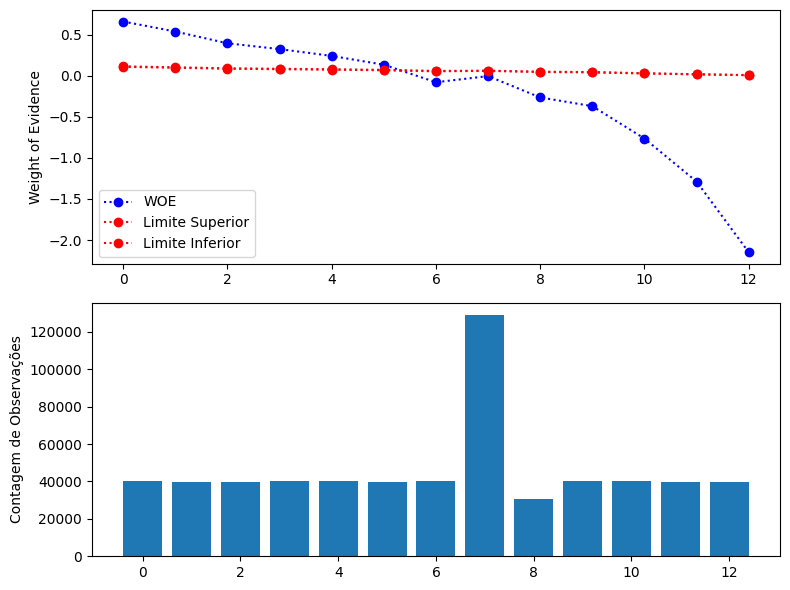

In [56]:
biv_continua('tempo_emprego', 15, df_train)

,categoria,qt_bom,qt_mau,mau,cont,ep,mau_sup,mau_inf,woe
0,0,30078,9924,0.248088,40002,0.002159,0.252320,0.243855,1.623853
1,1,34296,5708,0.142686,40004,0.001749,0.146113,0.139258,0.939531
2,2,35830,4167,0.104183,39997,0.001528,0.107177,0.101189,0.581102
3,3,36634,3365,0.084127,39999,0.001388,0.086847,0.081407,0.345142
4,4,37255,2749,0.068718,40004,0.001265,0.071197,0.066239,0.126142
5,5,37796,2199,0.054982,39995,0.001140,0.057216,0.052748,-0.111509
6,6,38095,1907,0.047673,40002,0.001065,0.049761,0.045585,-0.261861
7,7,38363,1634,0.040853,39997,0.000990,0.042793,0.038913,-0.423371
8,8,38679,1326,0.033146,40005,0.000895,0.034900,0.031392,-0.640439
9,9,38885,1120,0.027997,40005,0.000825,0.029613,0.026380,-0.814589


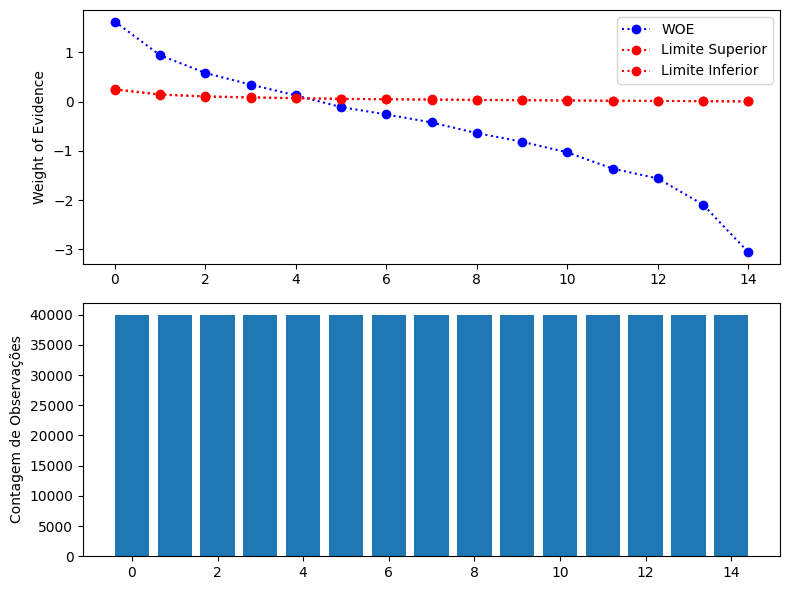

In [57]:
biv_continua('renda', 15, df_train)

In [58]:
# Ordena o DataFrame pelo valor da IV em ordem decrescente e pega o índice
indices_ordenados = metadados.sort_values(by='IV', ascending=False).index

# Junta os índices em uma string com ' + ' como separador
resultado = ' + '.join(indices_ordenados)

# Exibe ou utiliza o resultado conforme necessário
print(resultado)


qt_pessoas_residencia + renda + tempo_emprego + idade + tipo_renda + posse_de_imovel + educacao + tipo_residencia + sexo + qtd_filhos + estado_civil + posse_de_veiculo + mau


In [60]:
# Definindo a fórmula da regressão logística
formula = (
    'mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + '
    'educacao + estado_civil + tipo_residencia + idade + tempo_emprego + renda'
)

# Ajustando o modelo de regressão logística
rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

# Exibindo o resumo do modelo ajustado
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599979
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2488e+05
Date:                Tue, 05 Nov 2024   Deviance:                   2.4965e+05
Time:                        23:38:32   Pearson chi2:                 1.57e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04260
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.4189      0.053    -26.825      0.000      -1.523      -1.315
sexo[T.M]                           -0.1255      0.013     -9.567      0.000      -0.151      -0.100
posse_de_veiculo[T.S]                0.0313      0.012      2.529      0.011       0.007       0.056
posse_de_imovel[T.S]                -0.0847      0.012     -7.178      0.000      -0.108      -0.062
tipo_renda[T.Empresário]            -0.0545      0.014     -3.900      0.000      -0.082      -0.027
tipo_renda[T.Pensionista]           -0.0411      0.020     -2.032      0.042      -0.081      -0.001
tipo_renda[T.Servidor público]      -0.0330      0.023     -1.421      0.155      -0.079       0.013
educacao[T.Sup Comp/Pós]            -0.0566      0.013     -4.326      0.000      -0.082      -0.031
estado_civil[T.Separado]             0.0374      0.024      1.574      0.116      -0.009       0.084
estado_civil[T.Solteiro]             0.0054      0.017      0.311      0.756      -0.029       0.039
estado_civil[T.União]                0.0472      0.020      2.322      0.020       0.007       0.087
estado_civil[T.Viúvo]               -0.0346      0.029     -1.192      0.233      -0.092       0.022
tipo_residencia[T.Casa]             -0.0879      0.044     -1.995      0.046      -0.174      -0.002
tipo_residencia[T.Com os pais]      -0.0731      0.050     -1.475      0.140      -0.170       0.024
tipo_residencia[T.Comunitário]      -0.1403      0.089     -1.572      0.116      -0.315       0.035
tipo_residencia[T.Estúdio]          -0.0327      0.082     -0.397      0.691      -0.194       0.129
tipo_residencia[T.Governamental]    -0.0834      0.053     -1.565      0.118      -0.188       0.021
qtd_filhos                           0.0036      0.008      0.448      0.654      -0.012       0.019
idade                                0.0003      0.001      0.394      0.693      -0.001       0.002
tempo_emprego                       -0.0236      0.002    -13.100      0.000      -0.027      -0.020
renda                               -0.0001   1.09e-06    -93.691      0.000      -0.000   -9.96e-05
====================================================================================================
"""

In [61]:
# Fórmula de regressão logística
formula = (
    'mau ~ sexo + posse_de_imovel + educacao + tempo_emprego + renda'
)

# Ajustando o modelo de regressão logística
rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

# Exibindo o resumo do modelo ajustado
rl.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2490e+05
Date:                Tue, 05 Nov 2024   Deviance:                   2.4969e+05
Time:                        23:38:53   Pearson chi2:                 1.59e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04253
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.4931      0.014   -107.439      0.000      -1.520      -1.466
sexo[T.M]                   -0.1072      0.012     -8.926      0.000      -0.131      -0.084
posse_de_imovel[T.S]        -0.0897      0.011     -7.845      0.000      -0.112      -0.067
educacao[T.Sup Comp/Pós]    -0.0569      0.013     -4.477      0.000      -0.082      -0.032
tempo_emprego               -0.0245      0.002    -14.616      0.000      -0.028      -0.021
renda                       -0.0001   1.08e-06    -94.209      0.000      -0.000   -9.96e-05
============================================================================================
"""

In [63]:
# Fórmula de regressão logística
formula = '''
    mau ~ sexo + posse_de_imovel + educacao +
    tempo_emprego + renda
'''

# Ajustando o modelo de regressão logística
rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

# Exibindo o resumo do modelo ajustado
rl.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2490e+05
Date:                Tue, 05 Nov 2024   Deviance:                   2.4969e+05
Time:                        23:39:56   Pearson chi2:                 1.59e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04253
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.4931      0.014   -107.439      0.000      -1.520      -1.466
sexo[T.M]                   -0.1072      0.012     -8.926      0.000      -0.131      -0.084
posse_de_imovel[T.S]        -0.0897      0.011     -7.845      0.000      -0.112      -0.067
educacao[T.Sup Comp/Pós]    -0.0569      0.013     -4.477      0.000      -0.082      -0.032
tempo_emprego               -0.0245      0.002    -14.616      0.000      -0.028      -0.021
renda                       -0.0001   1.08e-06    -94.209      0.000      -0.000   -9.96e-05
============================================================================================
"""

In [64]:
# Fórmula de regressão logística com log(renda)
formula = '''
    mau ~ sexo + posse_de_imovel + educacao +
    tempo_emprego + np.log(renda)
'''

# Ajustando o modelo de regressão logística
rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

# Exibindo o resumo do modelo ajustado
rl.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2027e+05
Date:                Tue, 05 Nov 2024   Deviance:                   2.4055e+05
Time:                        23:40:16   Pearson chi2:                 5.97e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05720
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.9194      0.051    115.829      0.000       5.819       6.020
sexo[T.M]                   -0.0018      0.012     -0.149      0.882      -0.026       0.022
posse_de_imovel[T.S]        -0.0175      0.012     -1.494      0.135      -0.040       0.005
educacao[T.Sup Comp/Pós]    -0.0056      0.013     -0.430      0.667      -0.031       0.020
tempo_emprego               -0.0010      0.002     -0.610      0.542      -0.004       0.002
np.log(renda)               -0.9881      0.007   -149.914      0.000      -1.001      -0.975
============================================================================================
"""

In [65]:
# Fórmula de regressão logística com log(renda) como variável explicativa
formula = '''
    mau ~ np.log(renda)
'''

# Ajustando o modelo de regressão logística
rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

# Exibindo o resumo do modelo ajustado
rl.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2028e+05
Date:                Tue, 05 Nov 2024   Deviance:                   2.4055e+05
Time:                        23:40:45   Pearson chi2:                 5.97e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05719
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.9239      0.049    121.382      0.000       5.828       6.020
np.log(renda)    -0.9908      0.006   -169.858      0.000      -1.002      -0.979
=================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [ ]:
# Prevendo as probabilidades
df_train['score'] = rl.predict(df_train)

# Acurácia
acc = metrics.accuracy_score(df_train.mau, df_train.score > 0.068)

# Cálculo da AUC
fpr, tpr, thresholds = metrics.roc_curve(df_train.mau, df_train.score)
auc = metrics.auc(fpr, tpr)

# Cálculo do Gini
gini = 2 * auc - 1

# Cálculo do KS (Kolmogorov-Smirnov)
ks = ks_2samp(df_train.loc[df_train.mau == 1, 'score'],
              df_train.loc[df_train.mau == 0, 'score']).statistic

# Exibição dos resultados com formatação mais clara
print(f'Acurácia: {acc:.1%}')
print(f'AUC: {auc:.1%}')
print(f'GINI: {gini:.1%}')
print(f'KS: {ks:.1%}')


Acurácia: 71.9%
AUC: 77.0%
GINI: 54.0%
KS: 39.9%


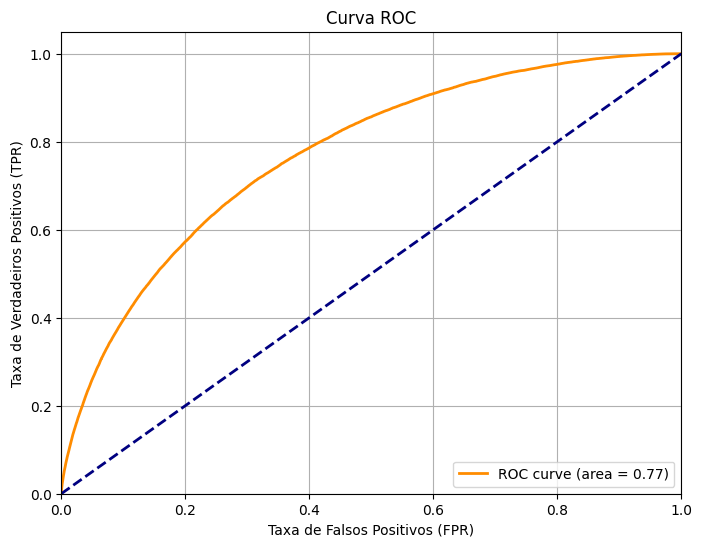

In [67]:
# Calcular a curva ROC
fpr, tpr, thresholds = metrics.roc_curve(df_train['mau'], df_train['score'])

# Calcular AUC
auc_ = metrics.auc(fpr, tpr)

# Plot da curva ROC
plt.figure(figsize=(8, 6))  # Define o tamanho da figura
lw = 2  # Largura da linha

# Plot da curva ROC
plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {auc_:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # Linha de chance aleatória

# Configurações do gráfico
plt.xlim([0.0, 1.0])  # Limites do eixo X (False Positive Rate)
plt.ylim([0.0, 1.05])  # Limites do eixo Y (True Positive Rate)
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')

# Adicionar o grid para melhor visualização
plt.grid(True)

# Legenda
plt.legend(loc="lower right")

# Exibir o gráfico
plt.show()


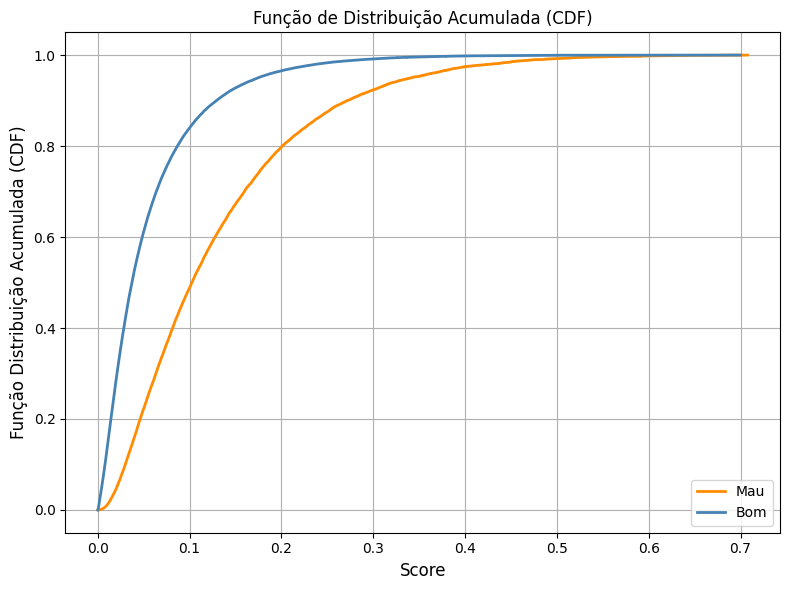

In [68]:
# Configuração do gráfico
fig, ax = plt.subplots(figsize=(8, 6))  # Tamanho do gráfico
ax.set_title('Função de Distribuição Acumulada (CDF)')

# Plotando a CDF para os 'Maus' (inadimplentes)
score_pop1 = df_train.loc[df_train['mau'] == 1, 'score']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Mau', color='darkorange', lw=2)

# Plotando a CDF para os 'Bons' (não inadimplentes)
score_pop2 = df_train.loc[df_train['mau'] != 1, 'score']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Bom', color='steelblue', lw=2)

# Configurações dos eixos
ax.set_xlabel('Score', fontsize=12)
ax.set_ylabel('Função Distribuição Acumulada (CDF)', fontsize=12)

# Legenda
ax.legend(loc="lower right")

# Adicionar grid para facilitar leitura
ax.grid(True)

# Exibir gráfico
plt.tight_layout()
plt.show()


In [71]:
# Out of time
df_test['tempo_emprego'].fillna(value=df_test['tempo_emprego'].mean(), inplace=True)

In [73]:
df_test.educacao.replace(
    {'Fundamental': 'Fund/Médio/Sup Incomp',
     'Médio': 'Fund/Médio/Sup Incomp',
     'Superior incompleto': 'Fund/Médio/Sup Incomp',
     'Superior completo': 'Sup Comp/Pós',
     'Pós graduação': 'Sup Comp/Pós'}, inplace=True)

In [74]:
# Calcular scores do modelo
df_test['score'] = rl.predict(df_test)

# Validar se as variáveis necessárias estão presentes
assert 'mau' in df_test.columns, "A coluna 'mau' não está presente no DataFrame"
assert 'score' in df_test.columns, "A coluna 'score' não está presente no DataFrame"

# Definir um limiar de decisão ideal com base no ponto de corte onde a AUC é maximizada ou outro critério
fpr, tpr, thresholds = metrics.roc_curve(df_test['mau'], df_test['score'])
roc_auc = metrics.auc(fpr, tpr)
optimal_idx = np.argmax(tpr - fpr)  # ponto de corte que maximiza a diferença entre TPR e FPR
optimal_threshold = thresholds[optimal_idx]

# Calcular a Acurácia com o limiar ideal
acc = metrics.accuracy_score(df_test['mau'], df_test['score'] > optimal_threshold)

# Calcular AUC
auc = roc_auc

# Calcular o Gini
gini = 2 * auc - 1

# Calcular o KS (Kolmogorov-Smirnov)
ks_statistic, p_value = ks_2samp(df_test.loc[df_test['mau'] == 1, 'score'],
                                  df_test.loc[df_test['mau'] == 0, 'score'])

# Exibir os resultados
print(f'Acurácia: {acc:.1%}')
print(f'AUC: {auc:.1%}')
print(f'GINI: {gini:.1%}')
print(f'KS: {ks_statistic:.1%}')


Acurácia: 67.4%
AUC: 73.9%
GINI: 47.8%
KS: 34.7%


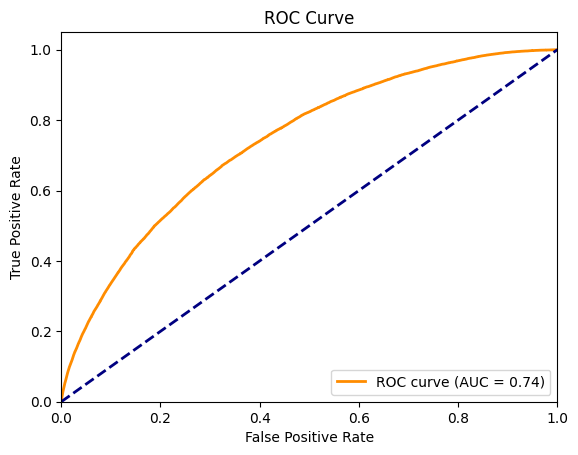

In [75]:
# Calcular a curva ROC
fpr, tpr, thresholds = metrics.roc_curve(df_test['mau'], df_test['score'])
auc_ = metrics.auc(fpr, tpr)

# Plotar a curva ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customizar gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Mostrar o gráfico
plt.show()


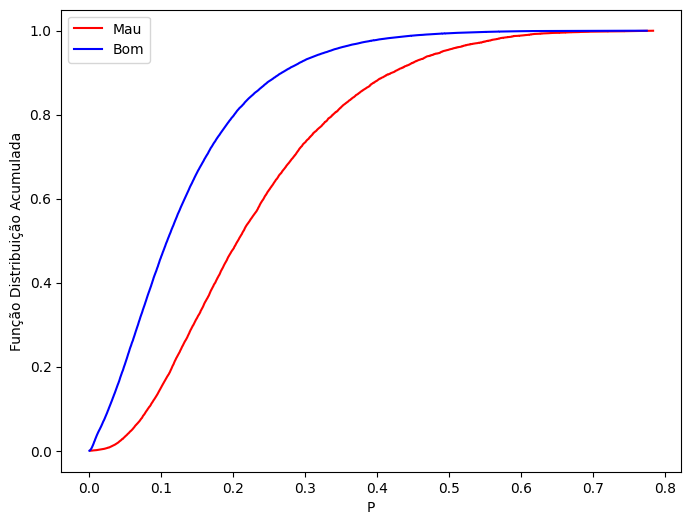

In [76]:
# Plotando a Função Distribuição Acumulada (CDF) para as duas classes
fig, ax = plt.subplots(figsize=(8, 6))

# Filtrando as observações de 'mau' e 'bom' e plotando a CDF
for label, color in zip([1, 0], ['red', 'blue']):
    score_pop = df_test.loc[df_test['mau'] == label, 'score']
    ax.plot(np.sort(score_pop), np.linspace(0, 1, len(score_pop), endpoint=False),
            label='Mau' if label == 1 else 'Bom', color=color)

# Customização do gráfico
ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')
ax.legend()

# Exibindo o gráfico
plt.show()


### Resumo Geral

A **queda da acurácia** observada pode ser atribuída ao **desbalanceamento de classes** ou à escolha de um limiar de decisão subótimo. No entanto, os valores de **AUC**, **GINI** e **KS** permanecem estáveis, o que indica que o modelo ainda é eficaz em **distinguir entre as classes**. 

Recomenda-se ajustar o limiar de decisão ou usar métricas como **AUC** e **KS** para avaliar melhor o desempenho do modelo, especialmente em contextos com **classes desbalanceadas**.
